In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Read and preprocess data

In [2]:
data_link = 'https://docs.google.com/spreadsheets/d/1VoB4dIH2Y2x2O-eH0ivNmBUYCcT-1NR6T5h8eWkE33Y/gviz/tq?tqx=out:csv&gid=1639699984'
df = pd.read_csv(data_link, index_col=0)

In [3]:
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['End Date'] = pd.to_datetime(df['End Date'])

In [30]:
df[df['Start Date']==pd.Timestamp("2021-12-17")].sort_values('Operations Amount (BGN)', ascending=False)

Operations Code                             Operations Description  \
162169         89 xxxx                                  Друго финансиране   
162293         60 xxxx       Трансфери за бюджетни и извънбюджетни сметки   
162104         30 xxxx                     Текущи субсидии за предприятия   
162004         01 xxxx  Заплати, възнаграждения и други плащания за пе...   
162297             NaN        Трансфери за други целеви разходи за общини   
...                ...                                                ...   
162149         93 xxxx  Закупуване на валута в брой, по сметка и за ди...   
162049         98 xxxx                               Други операции в БНБ   
162154         98 xxxx                               Други операции в БНБ   
162170         98 xxxx                               Други операции в БНБ   
162247         98 xxxx                               Други операции в БНБ   

        Operations Amount (BGN)  \
162169             7.507963e+08   
162293             3.918646e+07   
162104             3.317255e+07   
162004             2.164711e+07   
162297             1.824389e+07   
...                         ...   
162149             0.000000e+00   
162049            -2.000000e+02   
162154            -6.610100e+02   
162170            -2.108459e+04   
162247            -1.297537e+05   

                                        Organization Name Start Date  \
162169  Държавен фонд "Земеделие" - Разплащателна аген... 2021-12-17   
162293  Национален фонд - Оперативни програми, съфинан... 2021-12-17   
162104        Министерство на енергетиката ( 024******* ) 2021-12-17   
162004                  Висш съдебен съвет ( 006******* ) 2021-12-17   
162297           Други трансфери за общини ( 488******* ) 2021-12-17   
...                                                   ...        ...   
162149          Българско национално радио ( 062******* ) 2021-12-17   
162049  Министерство на труда и социалната политика ( ... 2021-12-17   
162154       Централна избирателна комисия ( 082******* ) 2021-12-17   
162170  Държавен фонд "Земеделие" - Разплащателна аген... 2021-12-17   
162247  Университет за национално и световно стопанств... 2021-12-17   

         End Date Organization ID                       Category  Latest Date  
162169 2021-12-17      122*******  Средства от ЕС и други донори        False  
162293 2021-12-17      987*******  Средства от ЕС и други донори        False  
162104 2021-12-17      024*******       Министерства и ведомства        False  
162004 2021-12-17      006*******                  Съдебна власт        False  
162297 2021-12-17      488*******             Средства за общини        False  
...           ...             ...                            ...          ...  
162149 2021-12-17      062*******               Обществени медии        False  
162049 2021-12-17      015*******       Министерства и ведомства        False  
162154 2021-12-17      082*******       Министерства и ведомства        False  
162170 2021-12-17      122*******  Средства от ЕС и други донори        False  
162247 2021-12-17      841*******            Висши училища и БАН        False  

[311 rows x 9 columns]

In [4]:
# df.head()

In [5]:
df_grouped_by_org = df.groupby(['Organization Name', 'Organization ID', 'Category', 'Start Date'], as_index=False).sum()
df_grouped_by_op = df.groupby(['Operations Code', 'Operations Description', 'Start Date'], as_index=False).sum()

In [6]:
# df.groupby(['Organization Name', 'Start Date'])['Operations Code'].apply(list)

In [7]:
unique_org_name = list(df['Organization Name'].unique())
id2name = {}
for org_name in unique_org_name:
    nm = org_name.split(' ( ')[0]
    org_id = org_name.split(' ( ')[-1].split()[0]
    id2name[org_id] = nm
    
    
unique_ops = df[['Operations Code', 'Operations Description']].drop_duplicates()
code2operation = {}
for _, row in unique_ops.iterrows():
    code = row['Operations Code']
    op = row['Operations Description']
    code2operation[code] = op


# Anomaly/Outlier detection

## Calc summary stats

In [8]:
def calc_stats(series):
    res = {}
    res['mean'] = me =  np.mean(series)
    res['std'] = std = np.std(series)
    res['norm_low'] = me - 2*std
    res['norm_high'] = me + 2*std
    
    qs = np.quantile(series, [0.25, 0.75])

    res['1Q'] = qs[0]
    res['3Q'] = qs[1]
    res['iqr'] = iqr = qs[1]-qs[0]
    res['iqr_low'] = qs[0] - 1.5*iqr
    res['iqr_high'] = qs[1] + 1.5*iqr
    
    return res

In [9]:
id2stats = {}
code2stats = {}

for org_id, _ in id2name.items():
    org_payments = df_grouped_by_org[(df_grouped_by_org['Organization ID']==org_id)].copy()

    id2stats[org_id] = {}
    if org_payments.shape[0] > 1:
#         plt.hist(org_payments['Operations Amount (BGN)'], bins=30)
#         plt.show()
        
        id2stats[org_id]['nonzero'] = calc_stats(org_payments['Operations Amount (BGN)'])
        
        date_fill_df = pd.DataFrame({
            'Start Date': pd.date_range(org_payments['Start Date'].min(), org_payments['Start Date'].max())
        })
        org_payments = date_fill_df.merge(org_payments, on='Start Date', how='left')
        org_payments['Operations Amount (BGN)'].fillna(0, inplace=True)
        
        id2stats[org_id]['zerofilled'] = calc_stats(org_payments['Operations Amount (BGN)'])

        
for cd, org_name in code2operation.items():
    op_payments = df_grouped_by_op[(df_grouped_by_op['Operations Code']==cd)].copy()   
    code2stats[cd] = {}
    if op_payments.shape[0] > 1:
        code2stats[cd]['nonzero'] = calc_stats(op_payments['Operations Amount (BGN)'])
        
        date_fill_df = pd.DataFrame({
            'Start Date': pd.date_range(op_payments['Start Date'].min(), op_payments['Start Date'].max())
        })
        op_payments = date_fill_df.merge(op_payments, on='Start Date', how='left')
        op_payments['Operations Amount (BGN)'].fillna(0, inplace=True)
        
        code2stats[cd]['zerofilled'] = calc_stats(op_payments['Operations Amount (BGN)'])


In [11]:
def classify_payments_norm(row, stats_dict):
    payment = row['Operations Amount (BGN)']
    
    norm_nonzero = 1*(
        (payment > stats_dict['norm_high']) or 
        ((payment < stats_dict['norm_low']))
    )
    return norm_nonzero
    
    
def classify_payments_iqr(row, stats_dict):    
    payment = row['Operations Amount (BGN)']    
    iqr_nonzero = 1*(
        (payment > stats_dict['iqr_high']) or 
        ((payment < stats_dict['iqr_low']))
    )
    return iqr_nonzero


def if_org_id(row, key, fn):
    if id2stats[row['Organization ID']]=={}:
        return np.nan
    return fn(row, id2stats[row['Organization ID']][key])
    

def if_code_id(row, key, fn):
    if code2stats[row['Operations Code']]=={}:
        return np.nan
    return fn(row, code2stats[row['Operations Code']][key])

## Classify data points by Organization ID

In [12]:
df_grouped_by_org['anomaly_norm_nonzero'] = df_grouped_by_org.apply(
    lambda row: if_org_id(row, 'nonzero', classify_payments_norm),
    axis=1
)
df_grouped_by_org['anomaly_norm_zerofilled'] = df_grouped_by_org.apply(
    lambda row: if_org_id(row, 'zerofilled', classify_payments_norm),
    axis=1
)
df_grouped_by_org['anomaly_iqr_nonzero'] = df_grouped_by_org.apply(
    lambda row: if_org_id(row, 'nonzero', classify_payments_iqr),
    axis=1
)
df_grouped_by_org['anomaly_iqr_zerofilled'] = df_grouped_by_org.apply(
    lambda row: if_org_id(row, 'zerofilled', classify_payments_iqr),
    axis=1
)

np.around(100*df_grouped_by_org[
    [c for c in df_grouped_by_org.columns if "anomaly" in c]
].sum()/df_grouped_by_org.shape[0], 2)

anomaly_norm_nonzero        4.80
anomaly_norm_zerofilled     7.32
anomaly_iqr_nonzero        12.54
anomaly_iqr_zerofilled     34.14
dtype: float64

## Plot

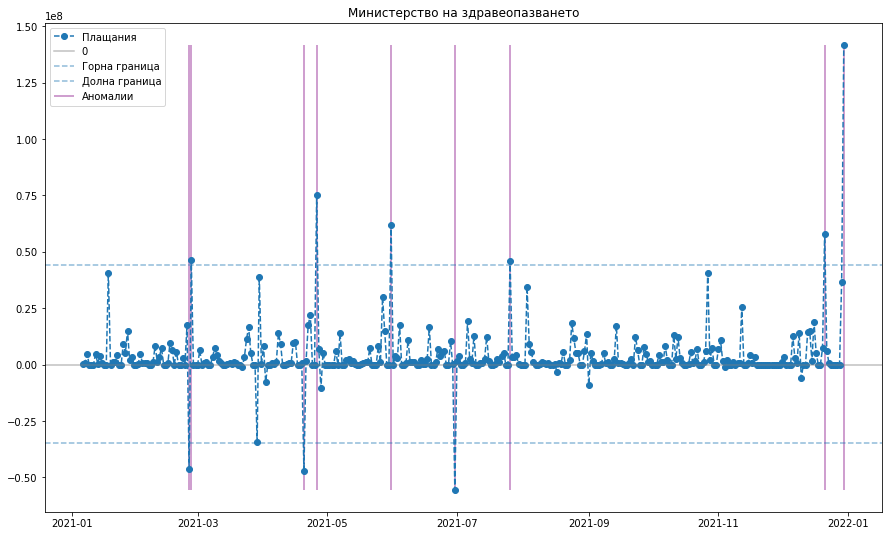

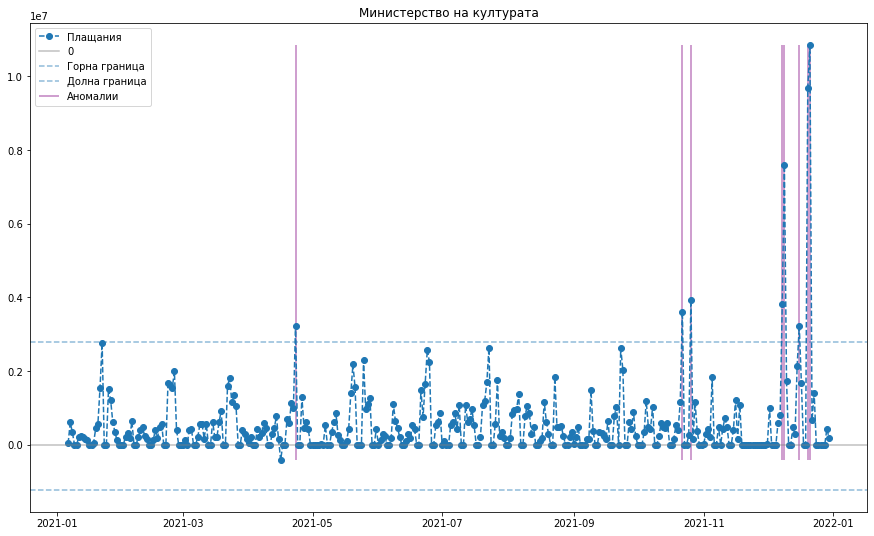

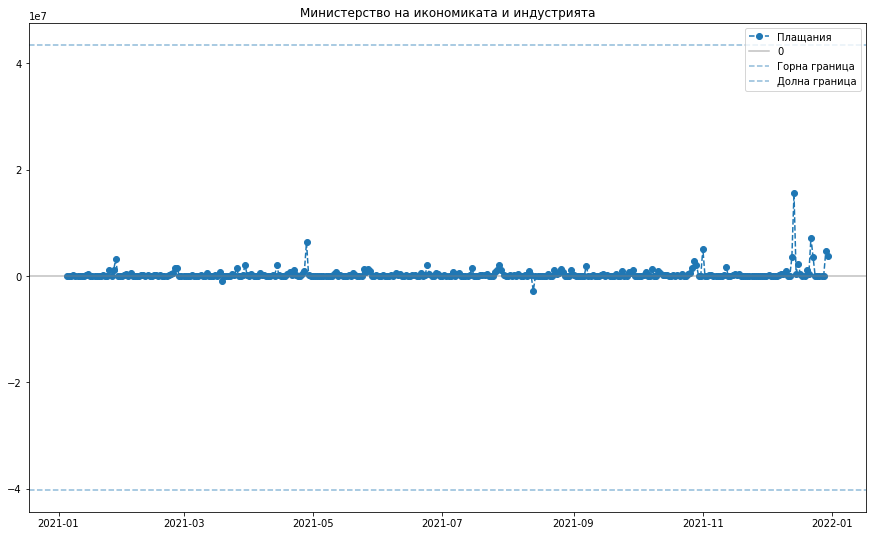

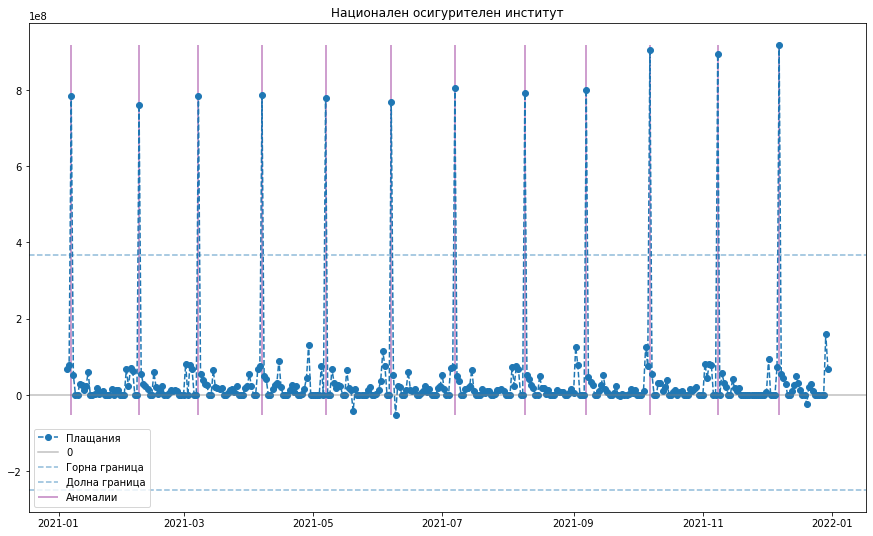

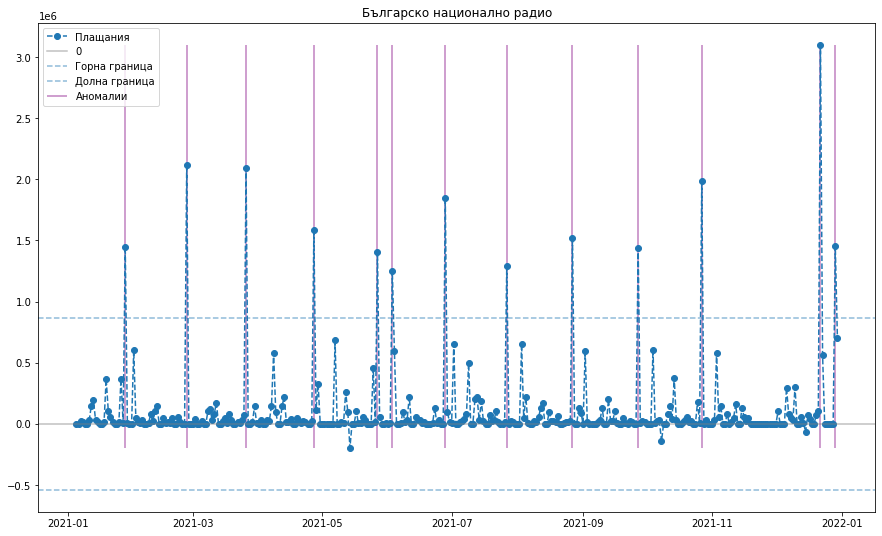

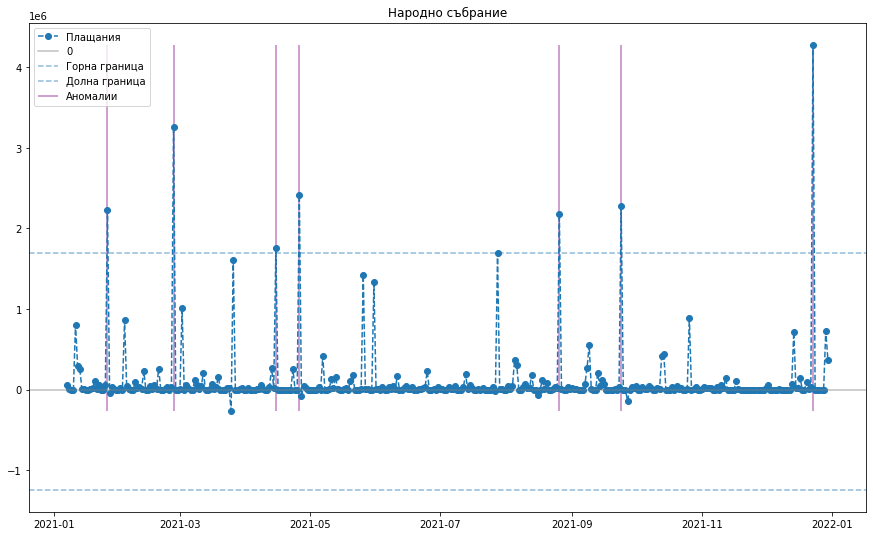

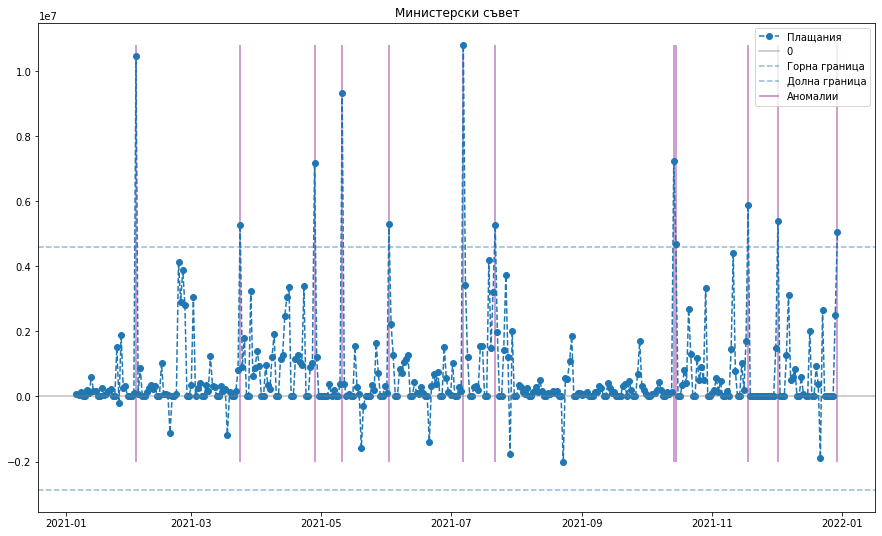

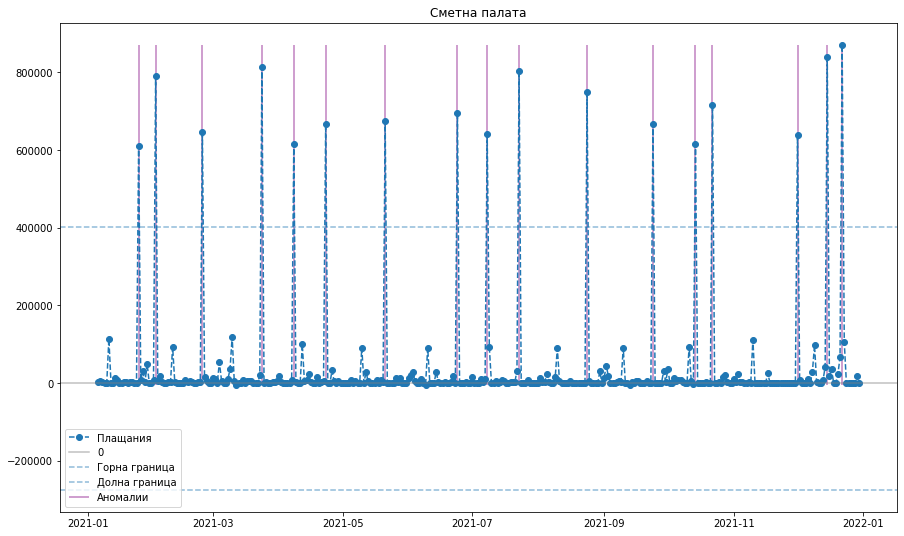

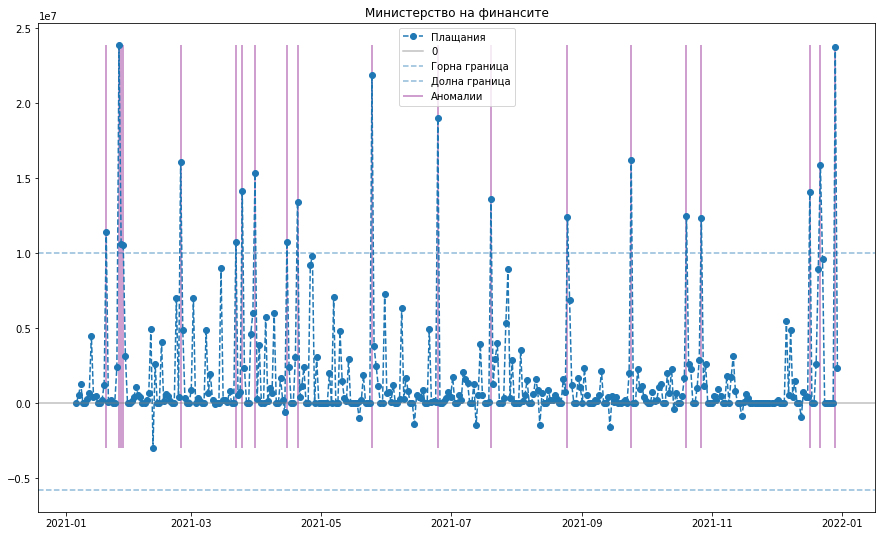

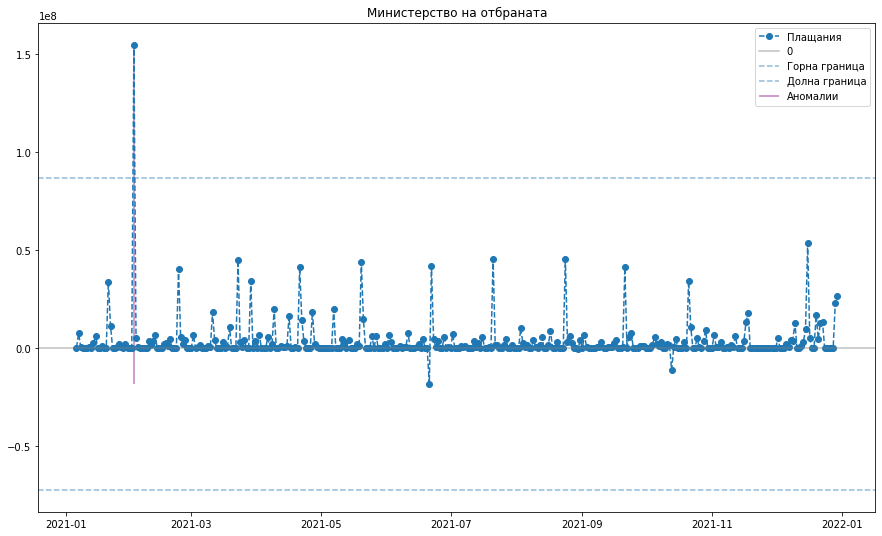

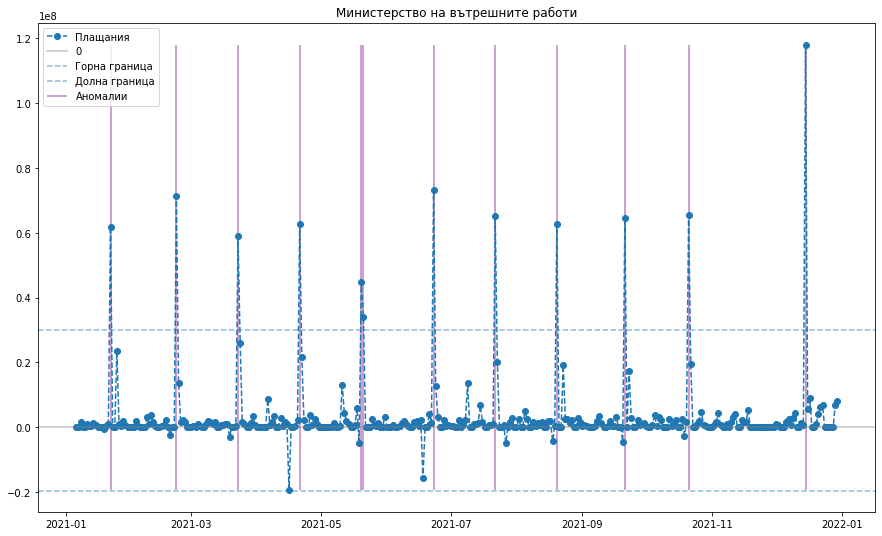

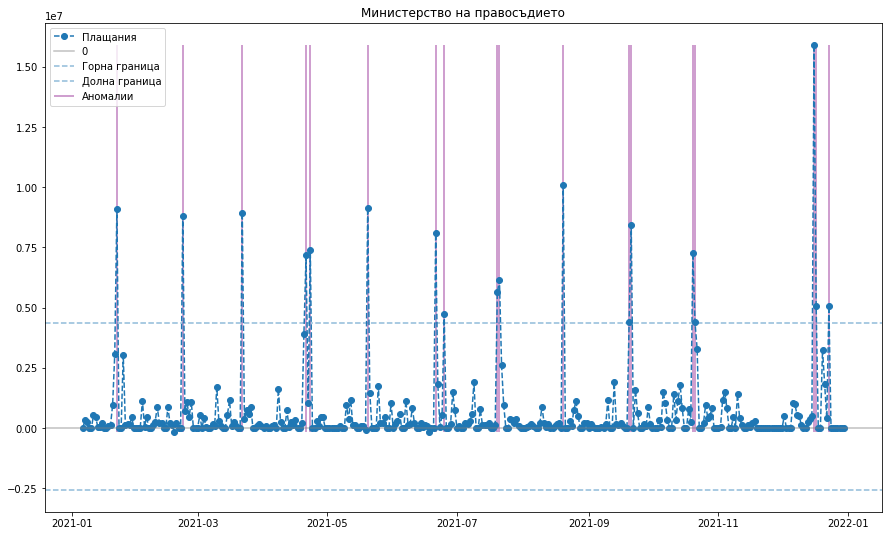

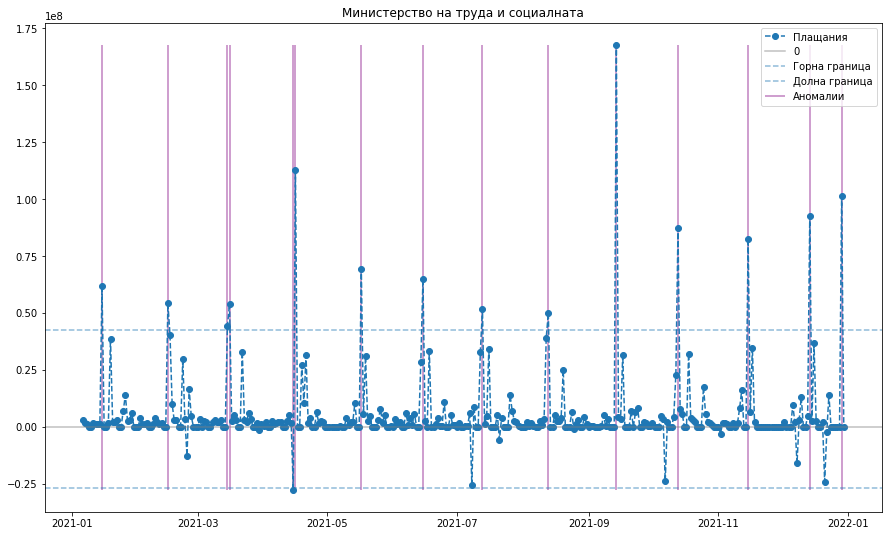

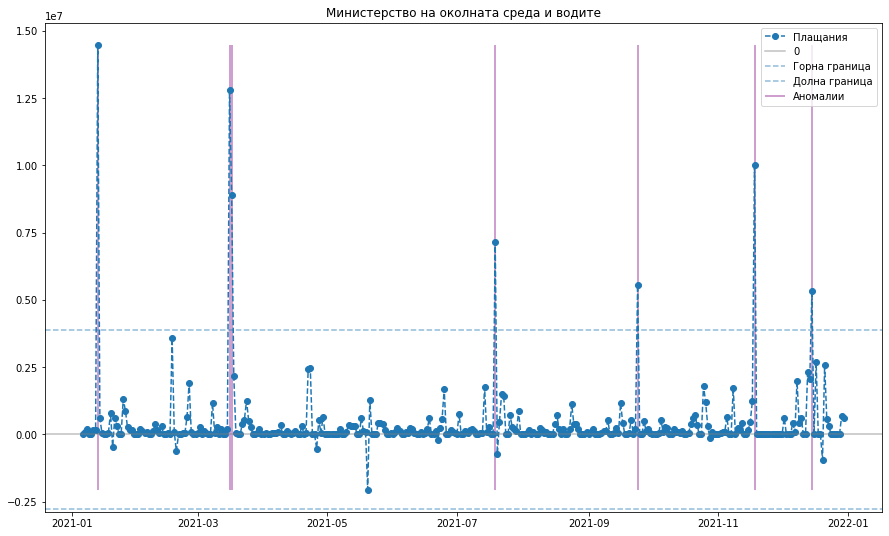

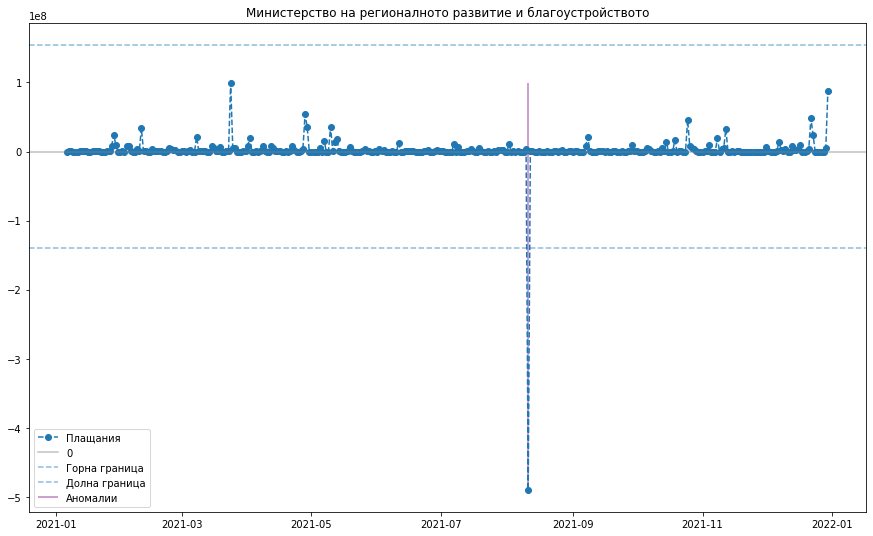

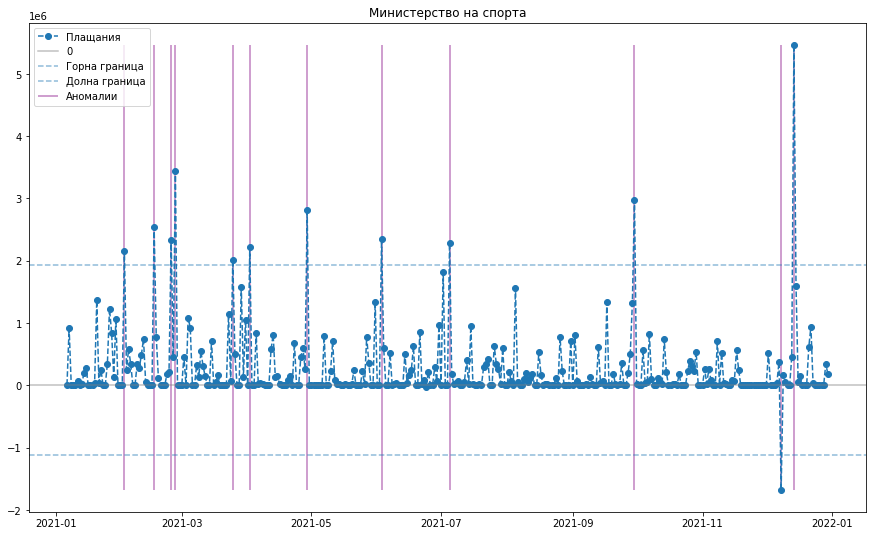

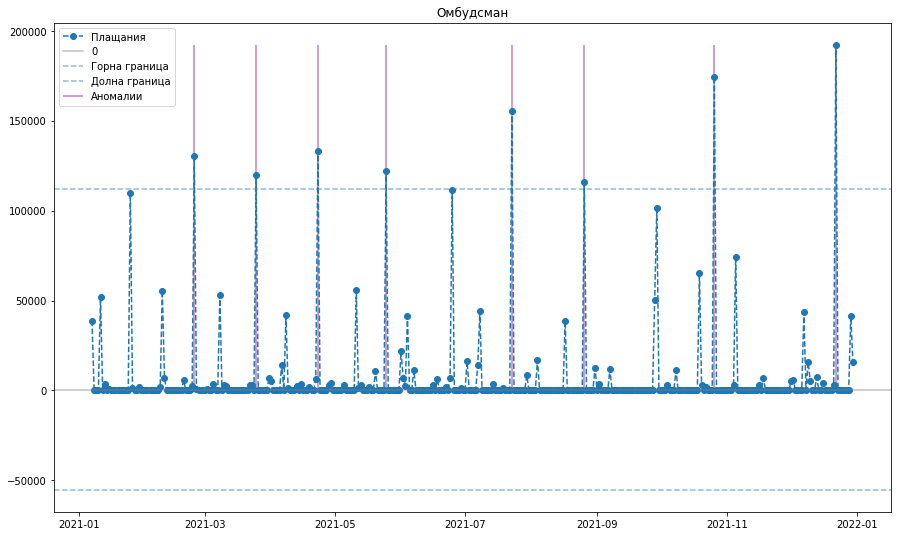

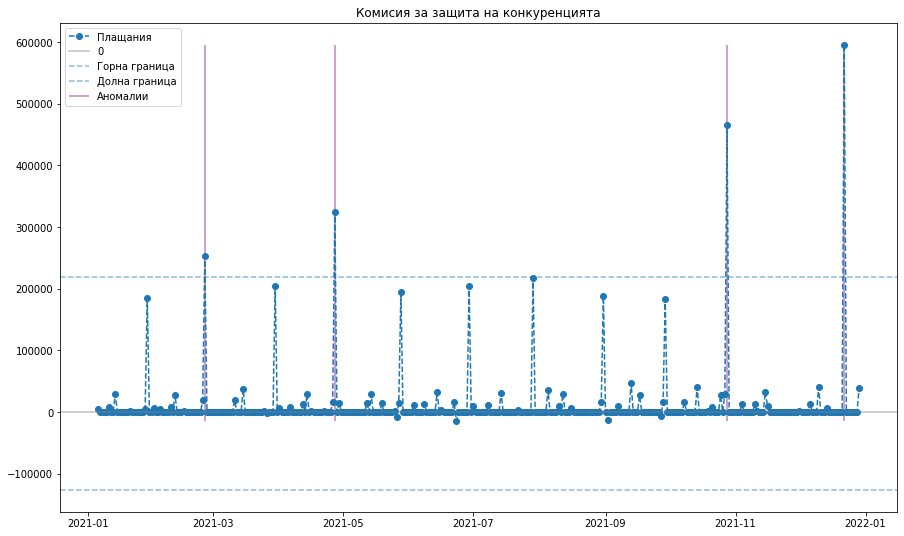

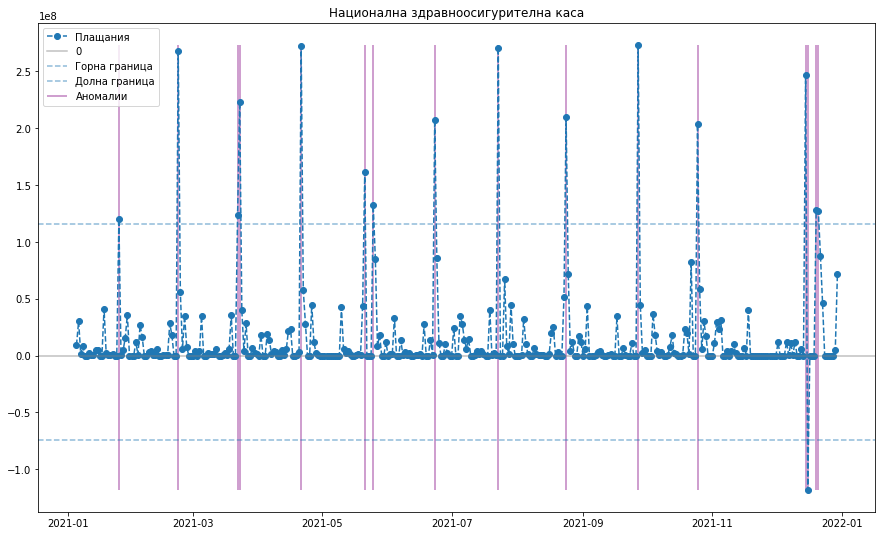

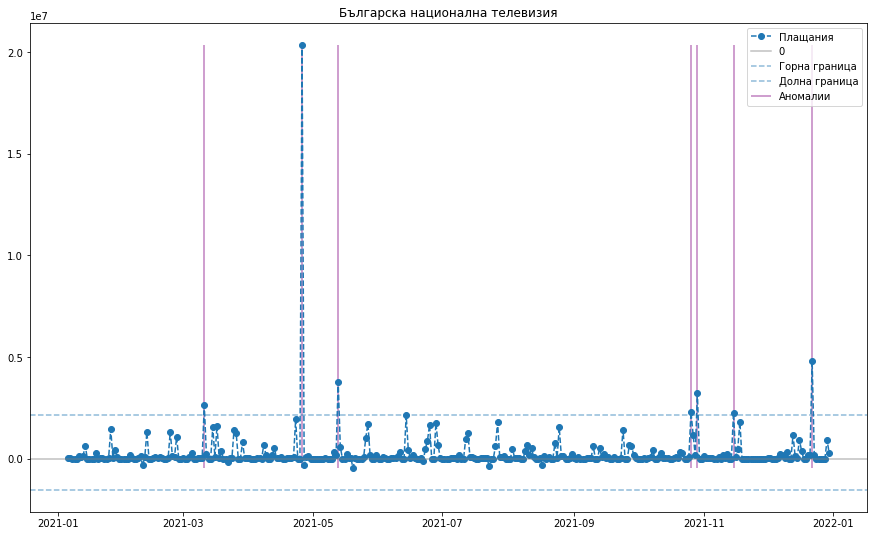

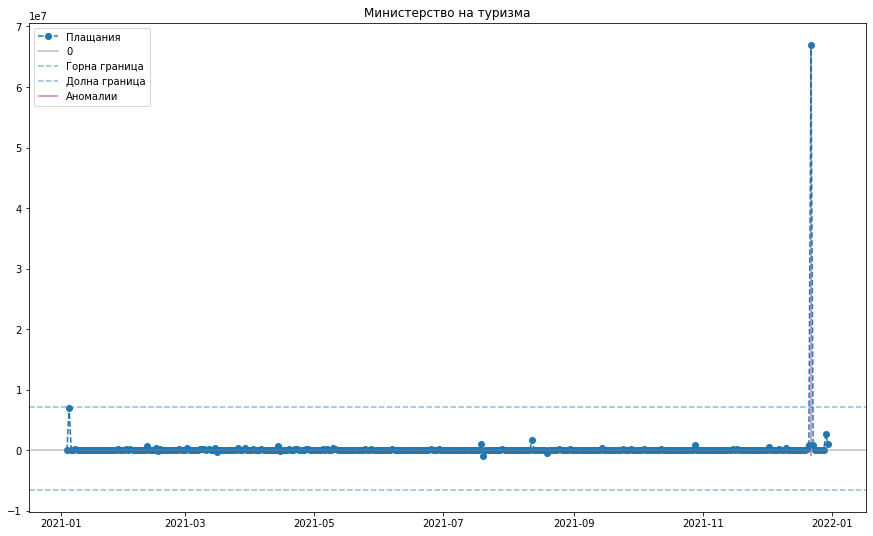

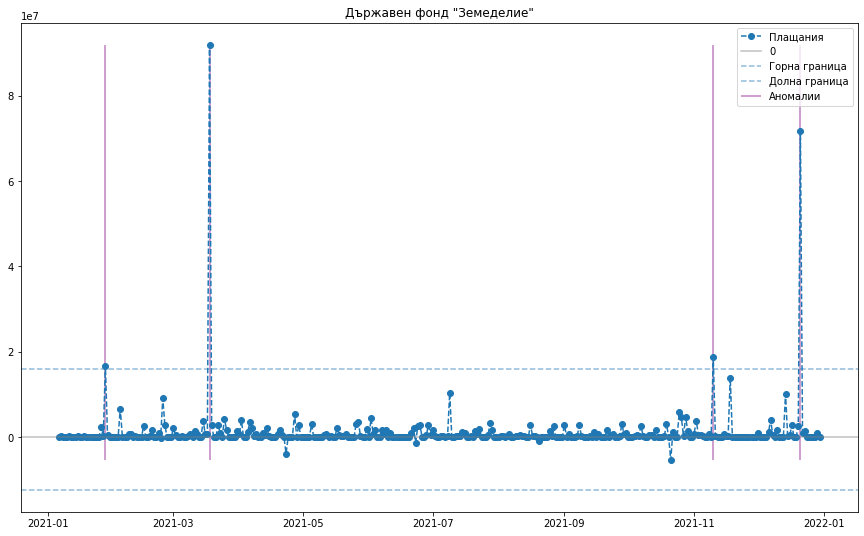

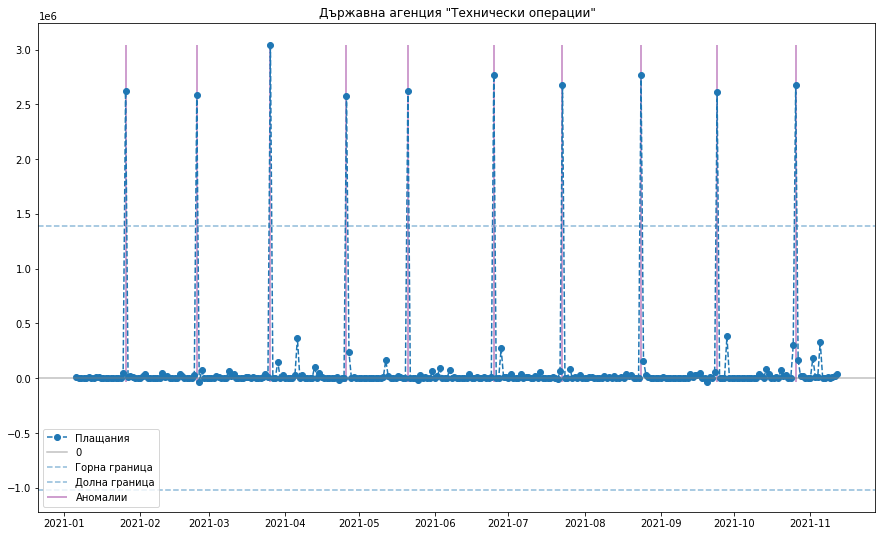

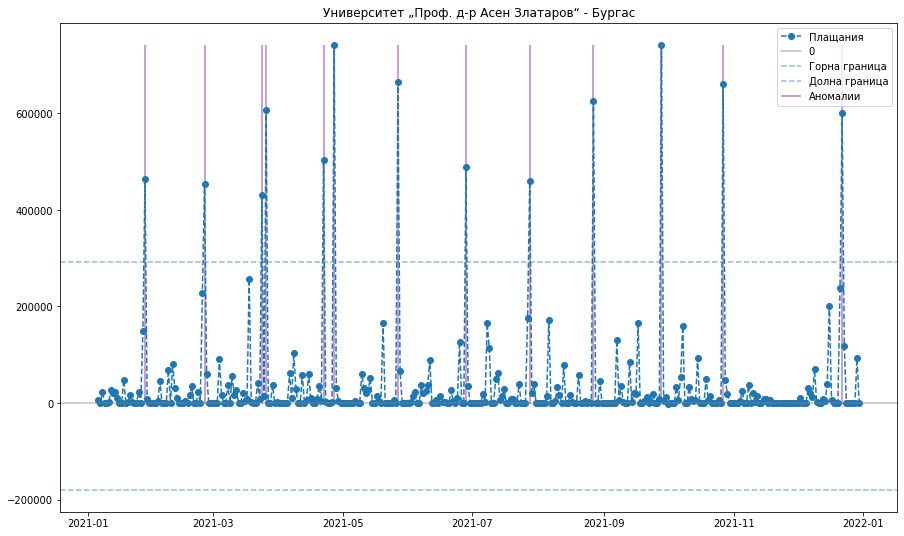

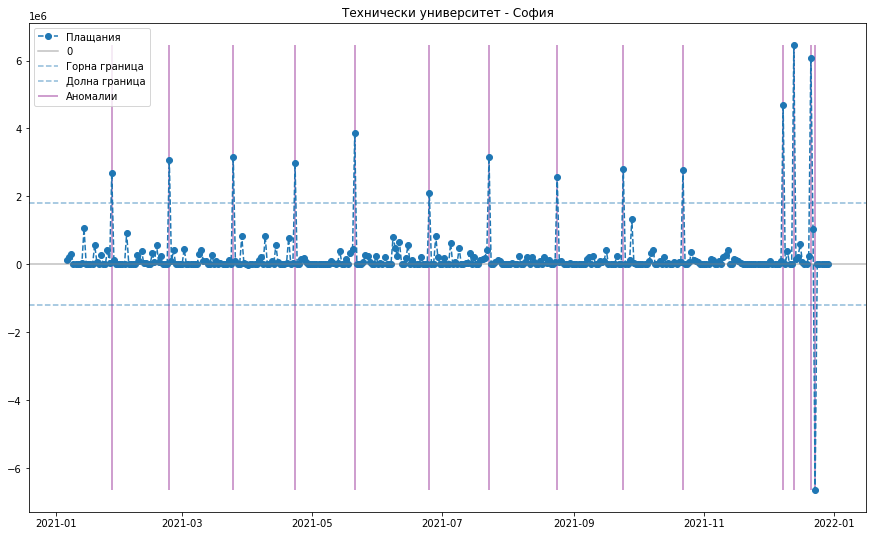

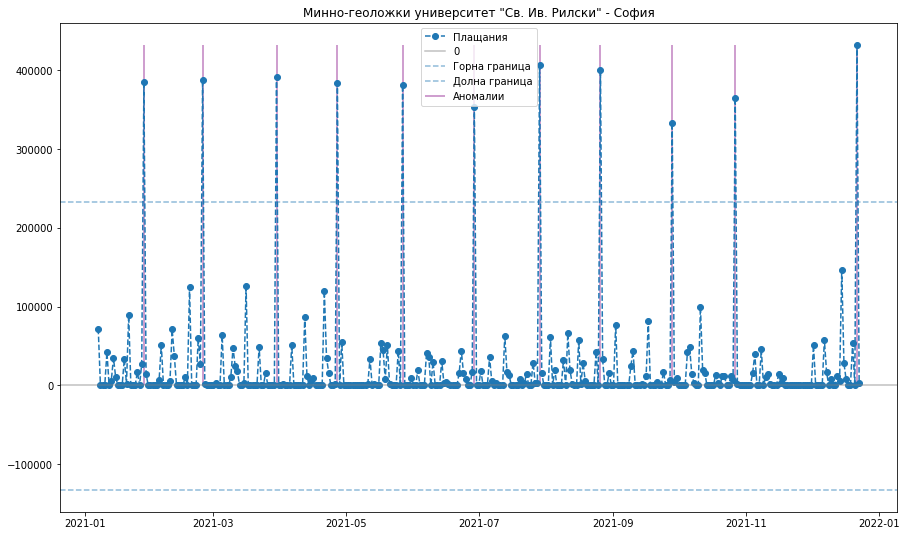

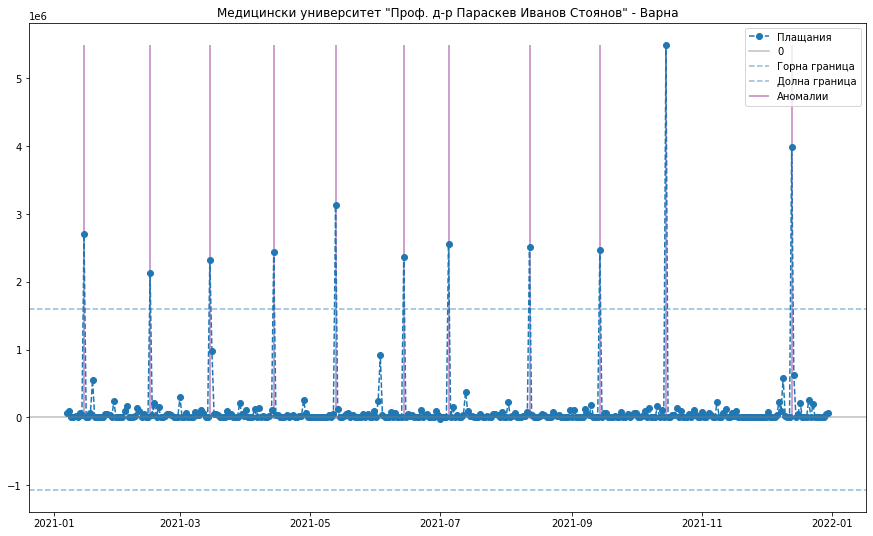

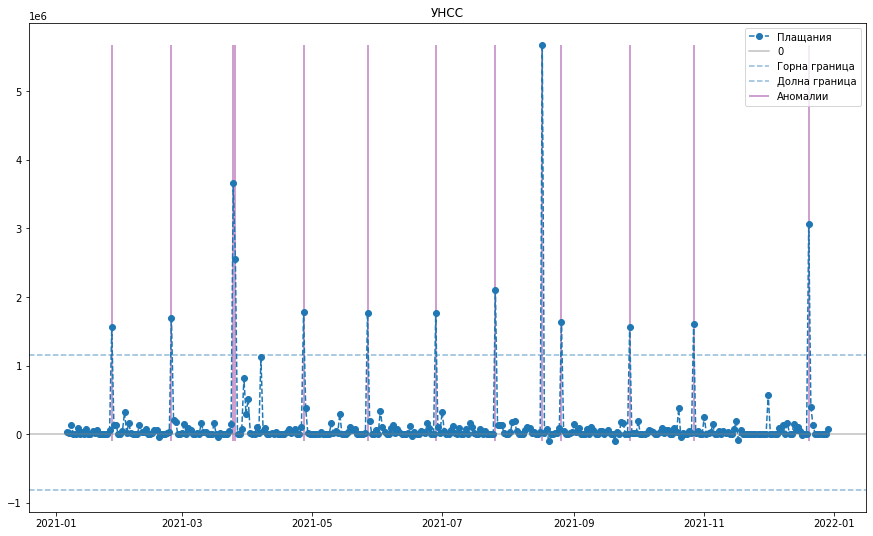

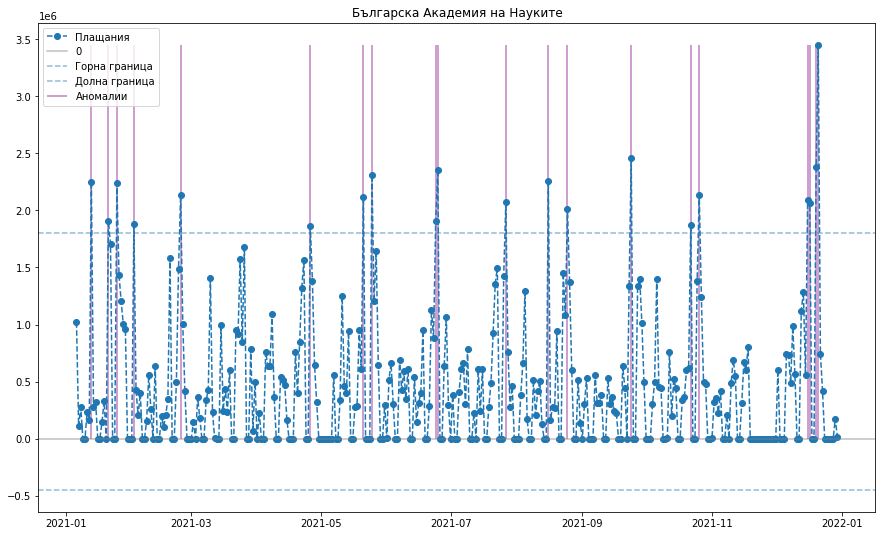

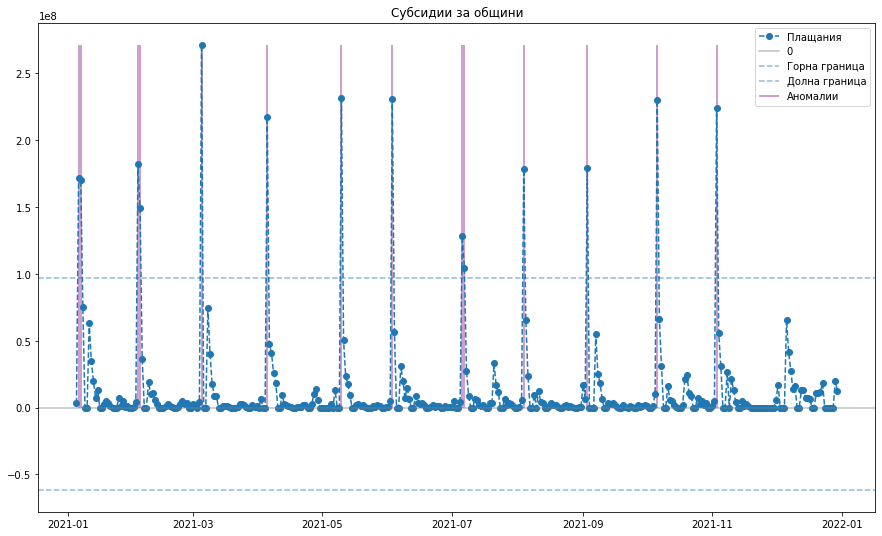

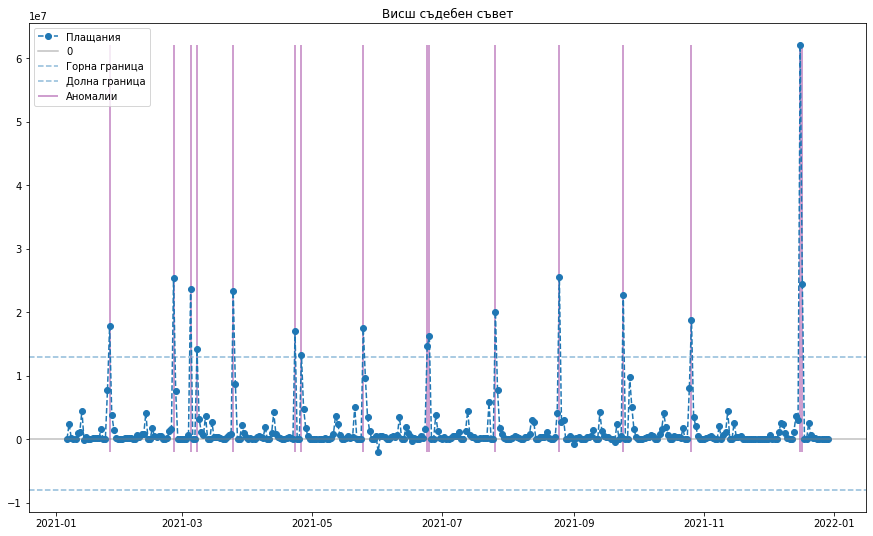

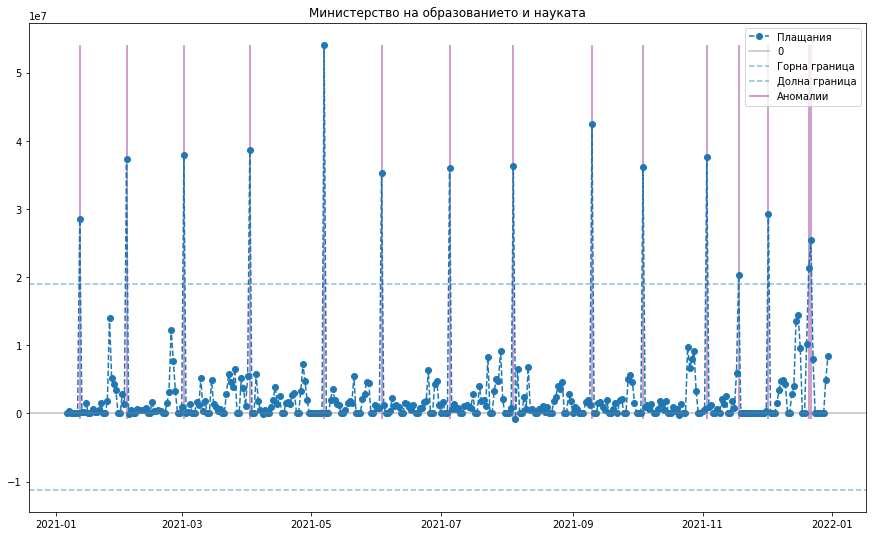

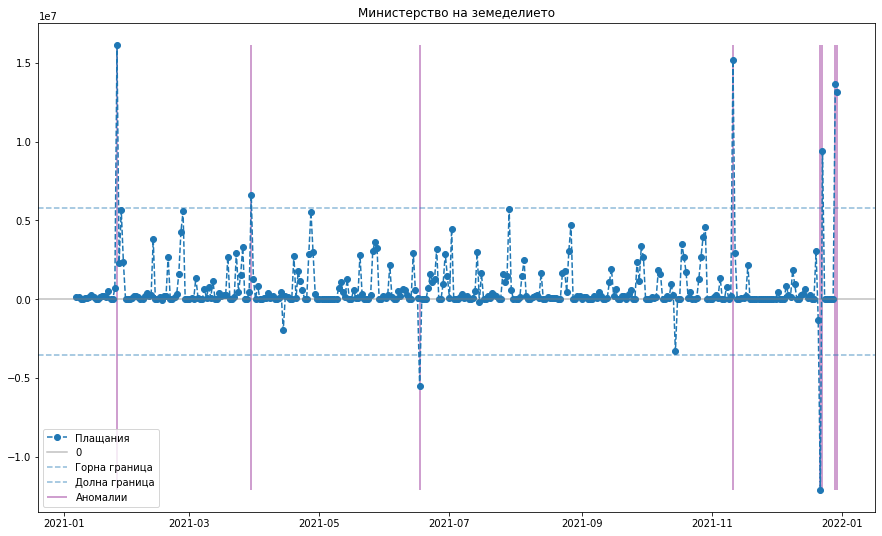

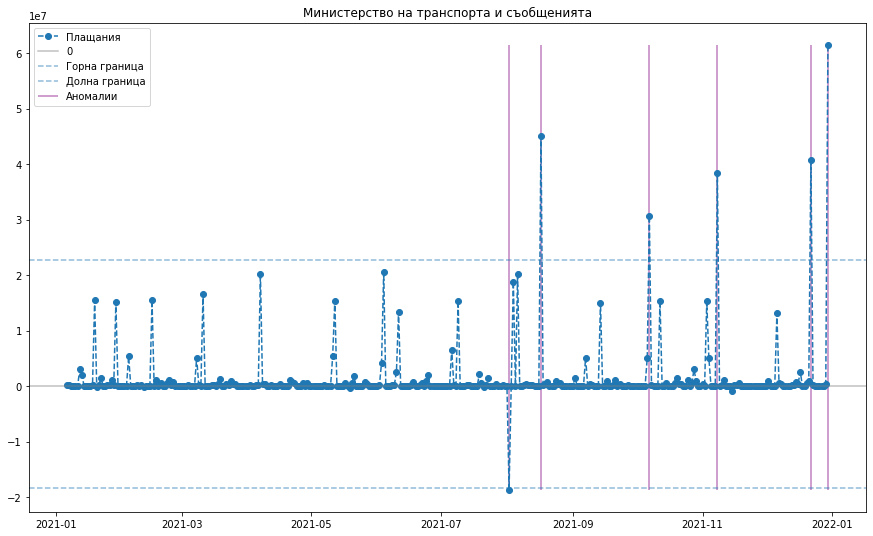

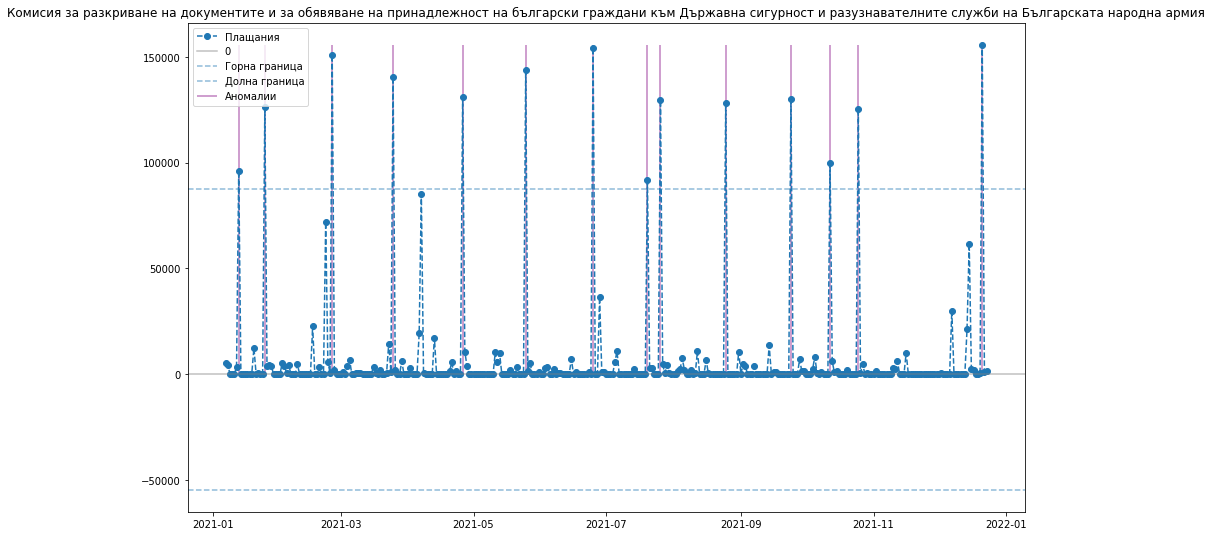

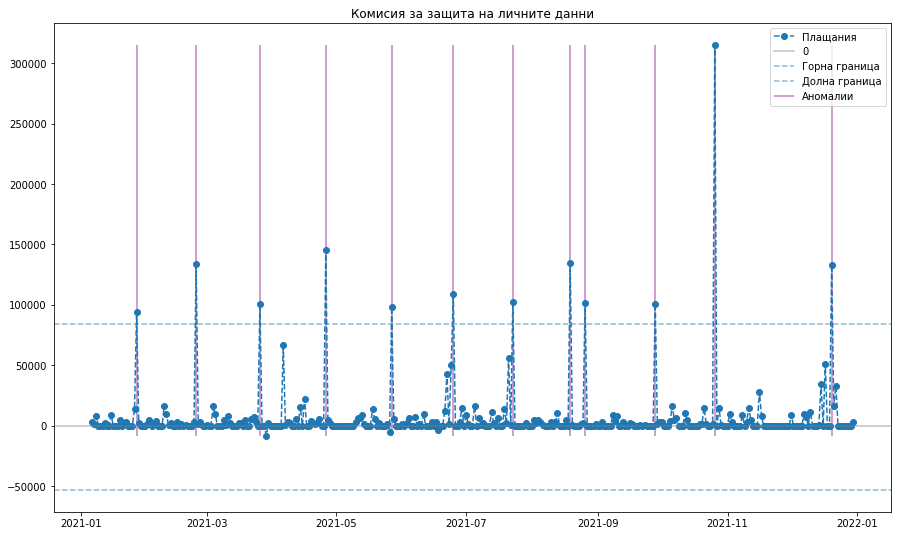

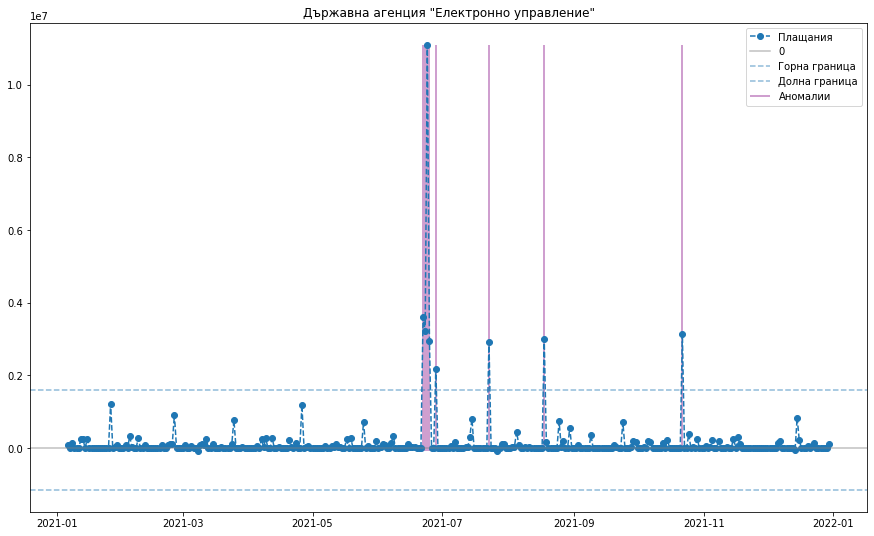

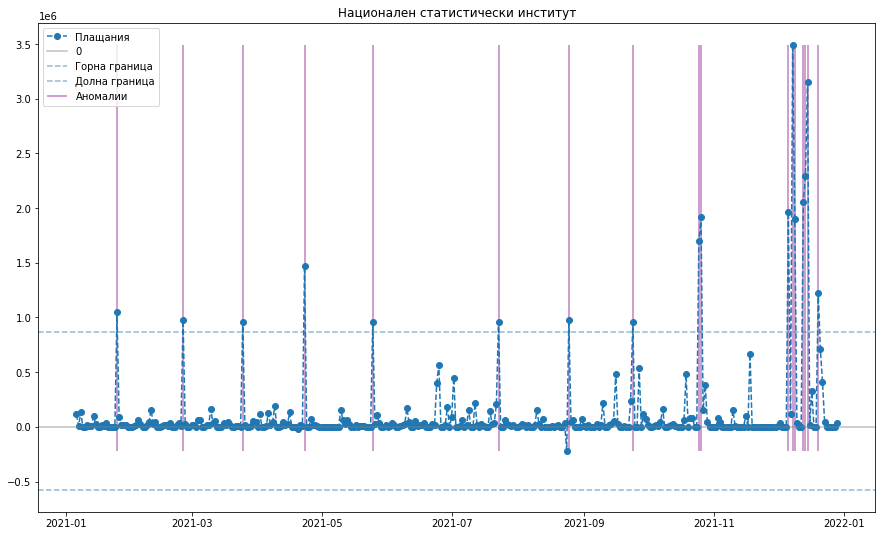

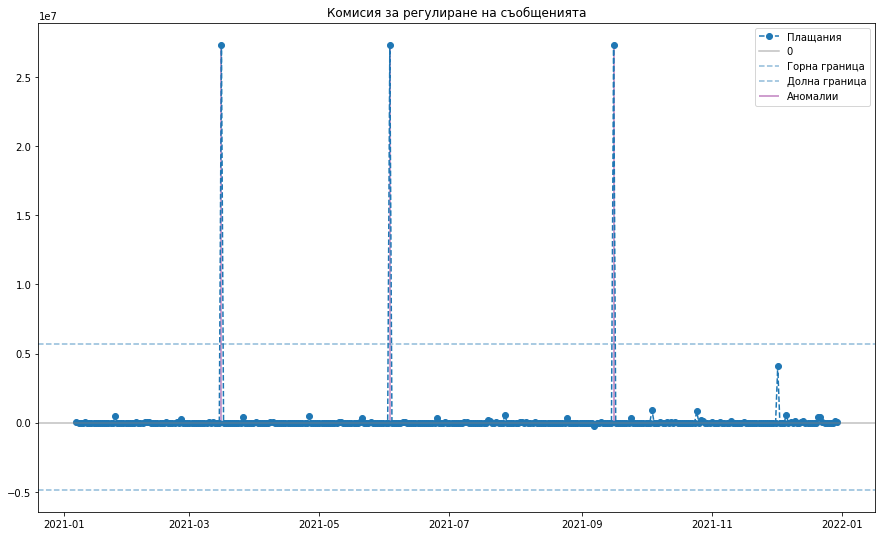

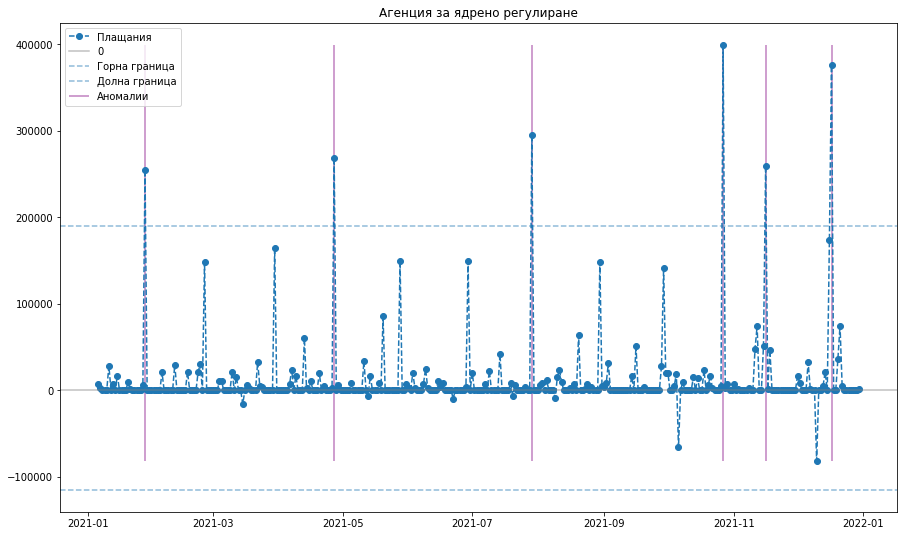

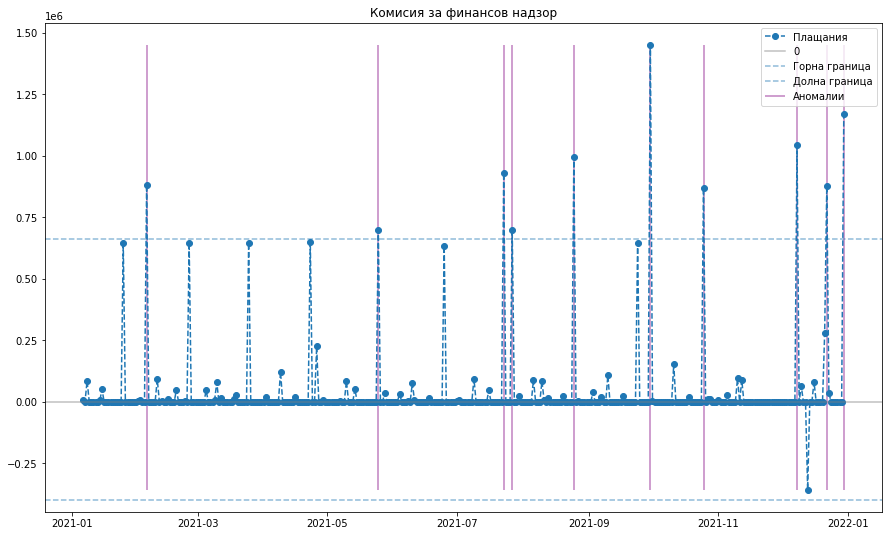

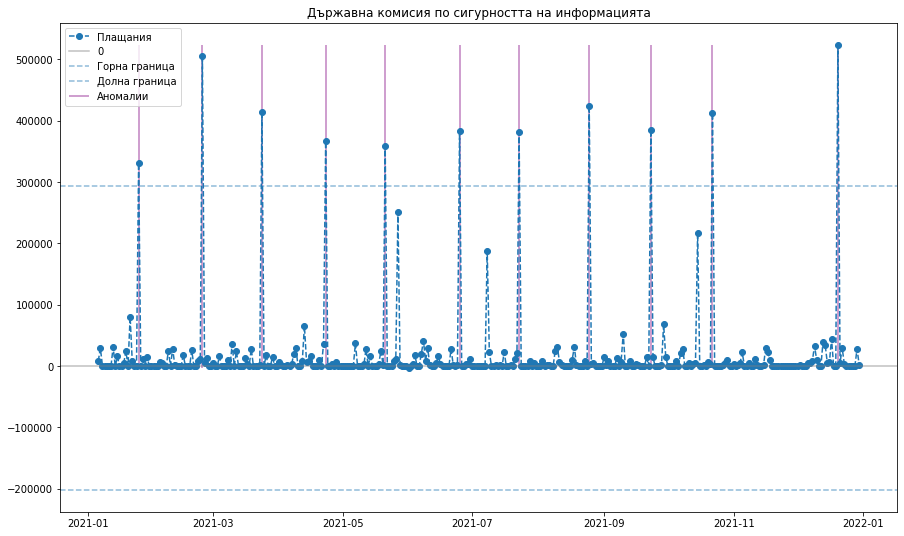

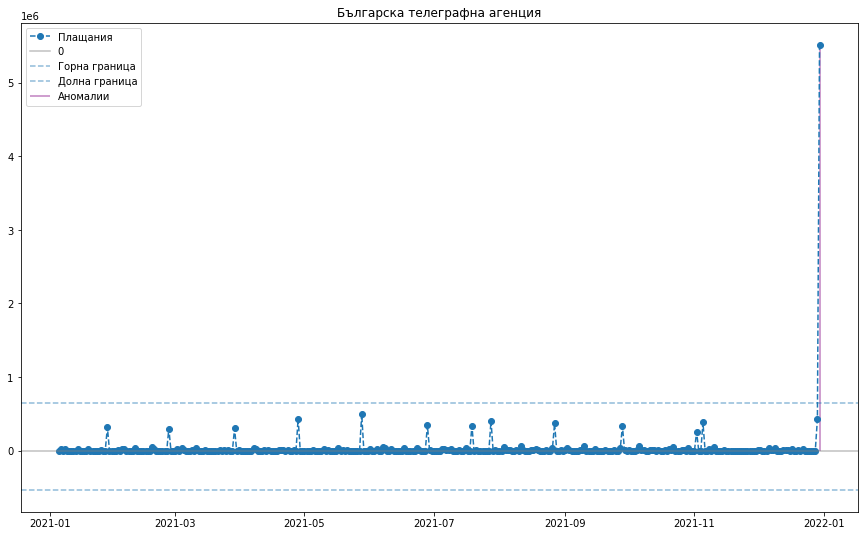

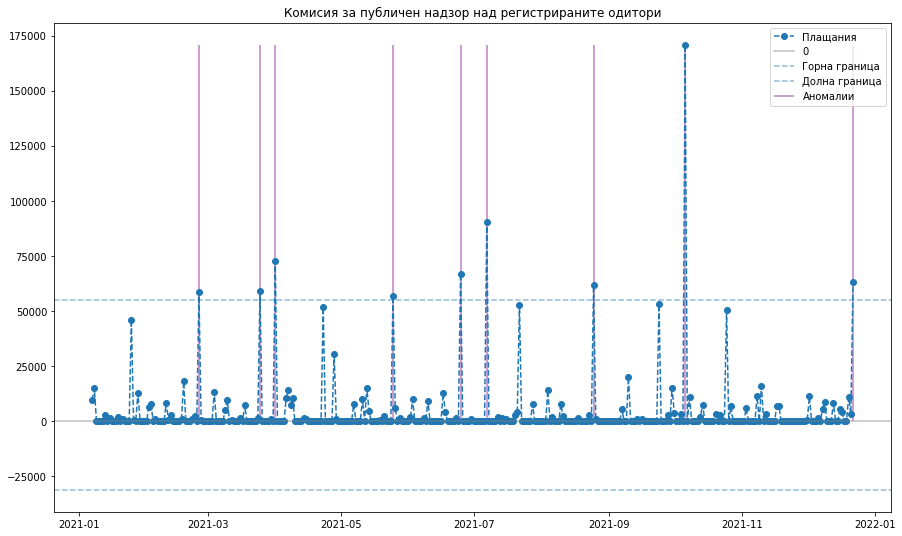

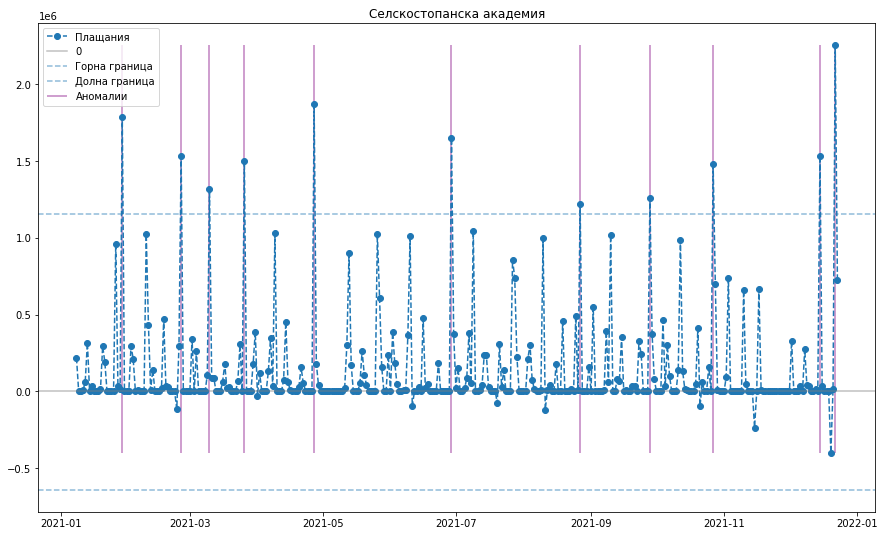

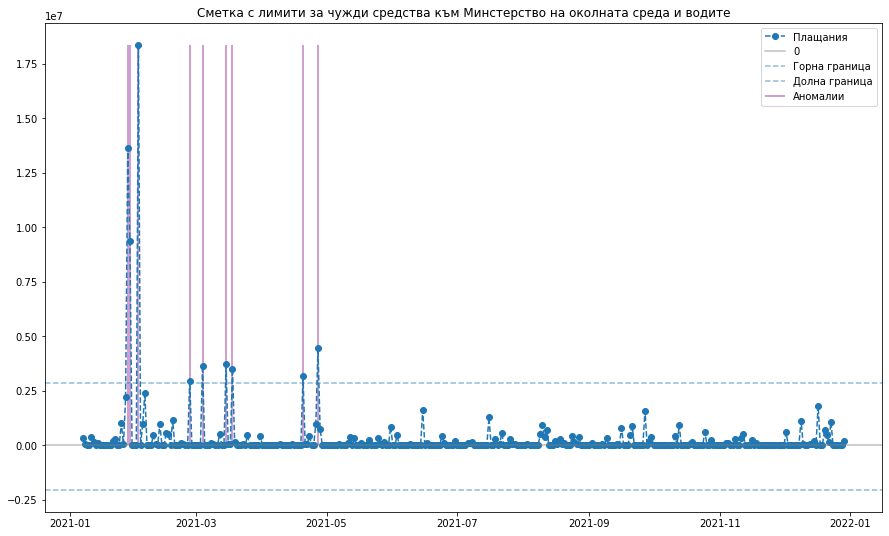

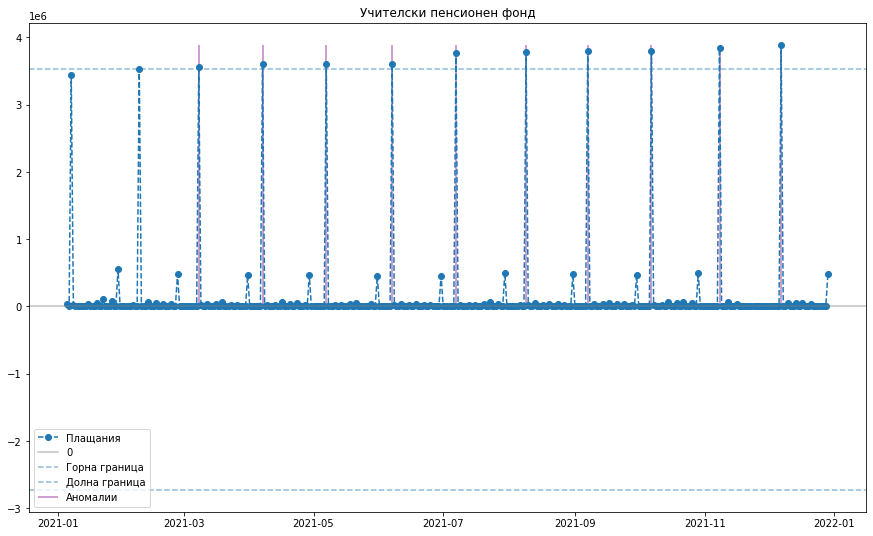

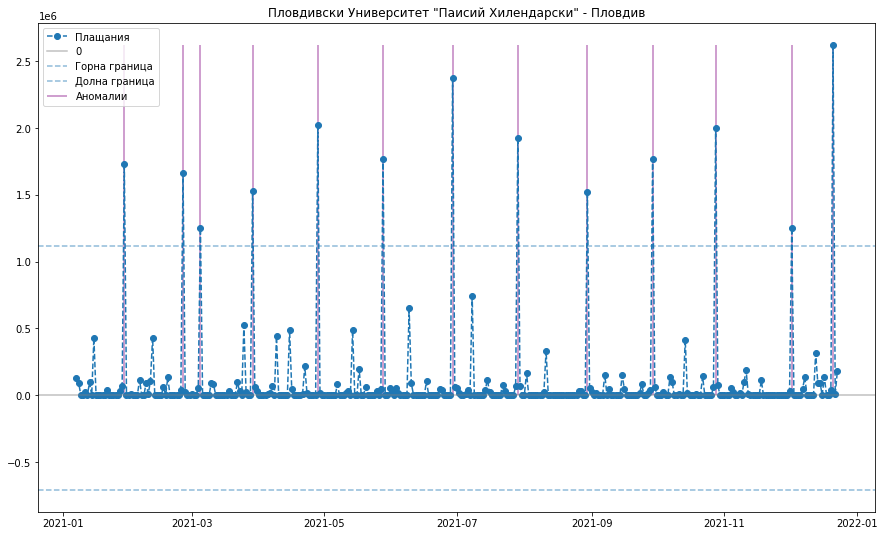

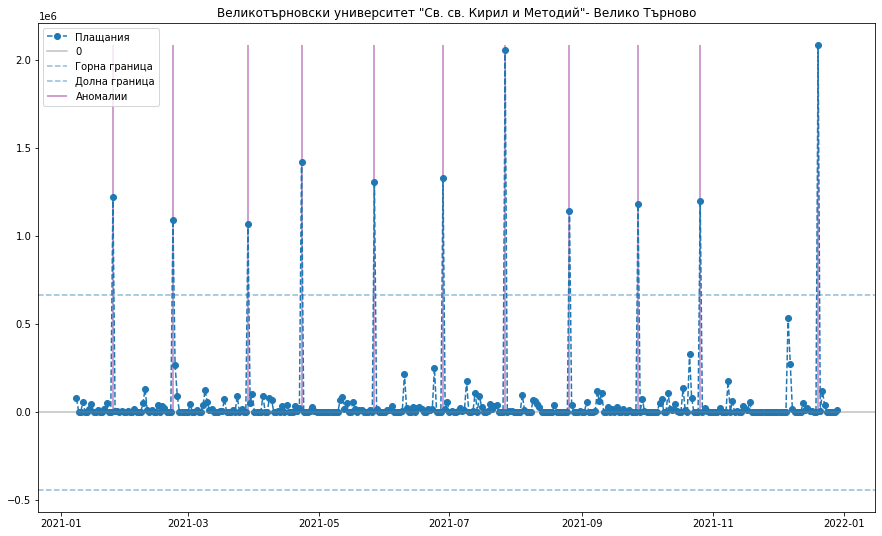

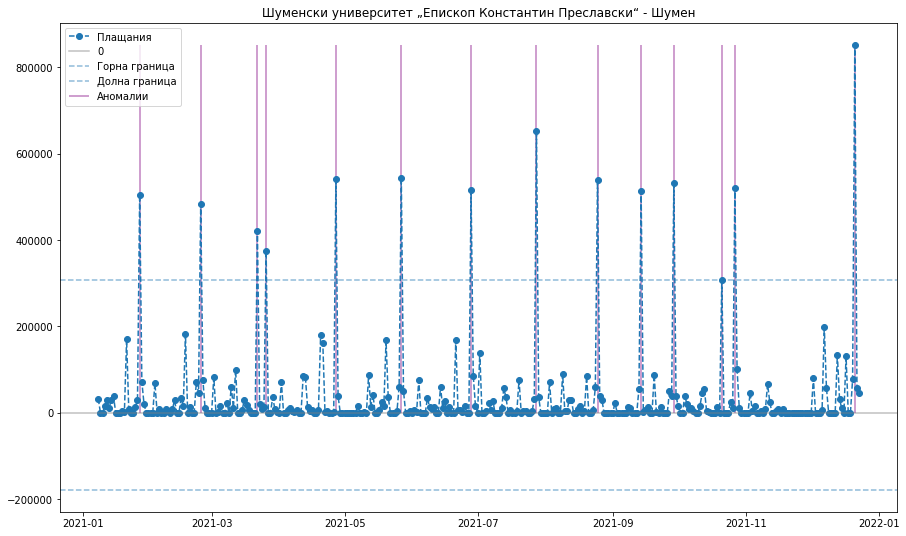

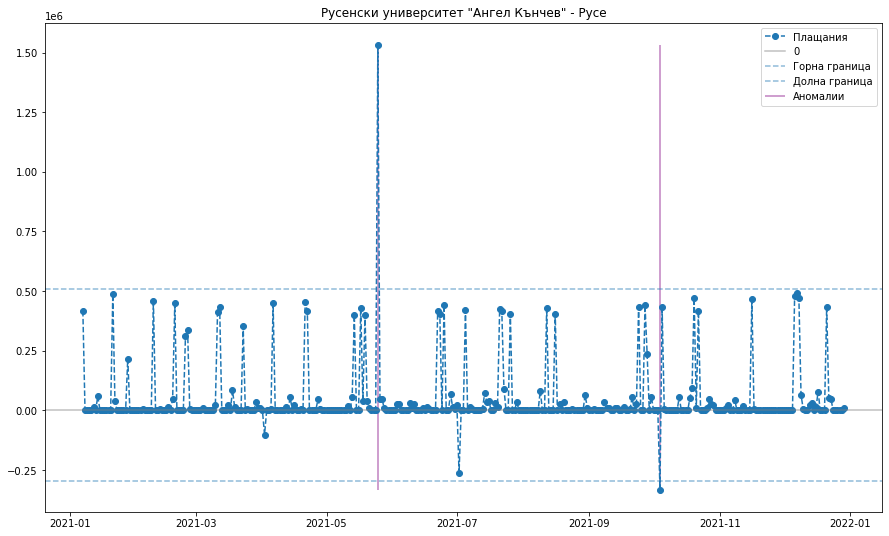

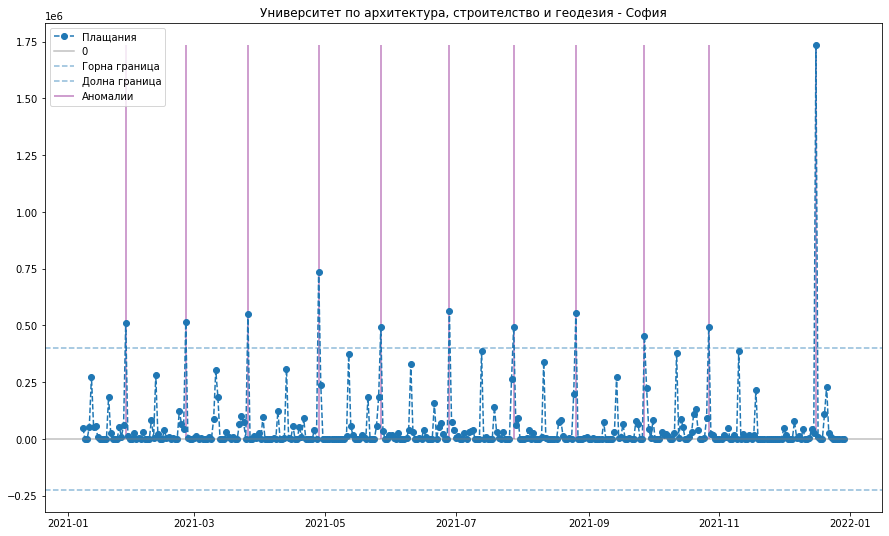

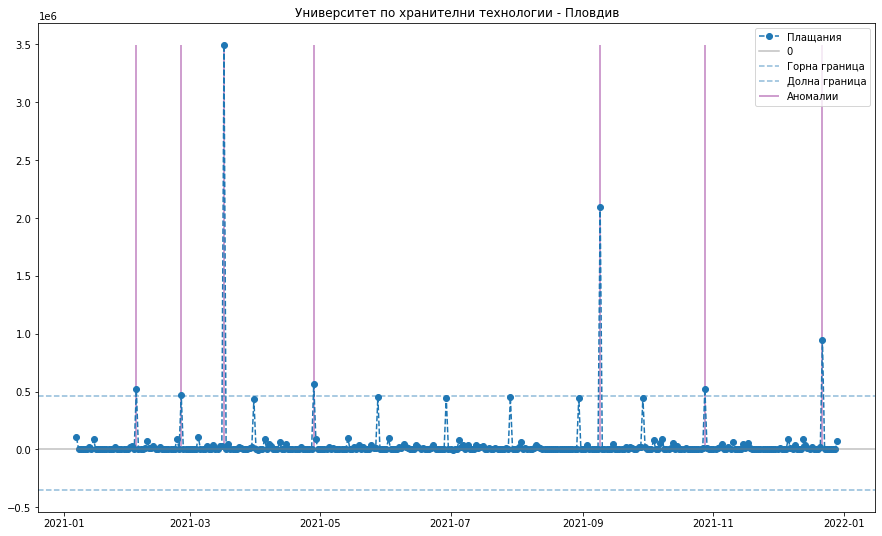

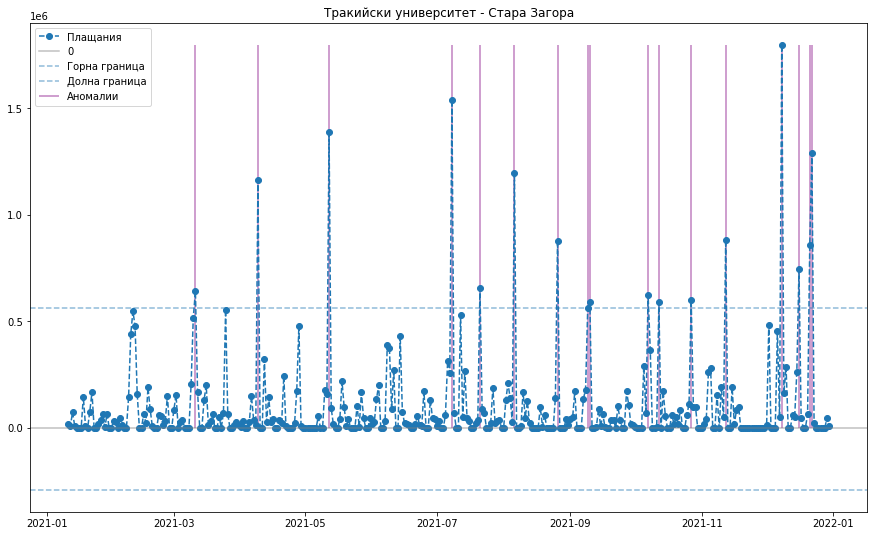

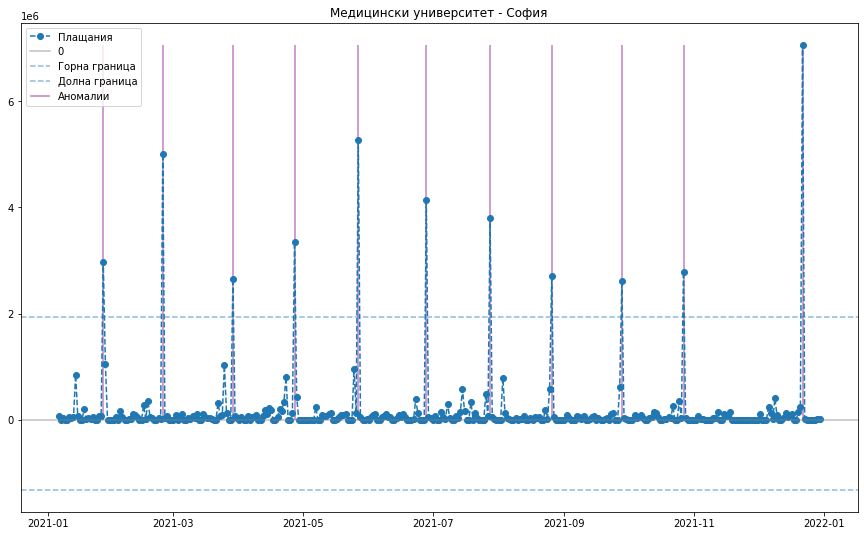

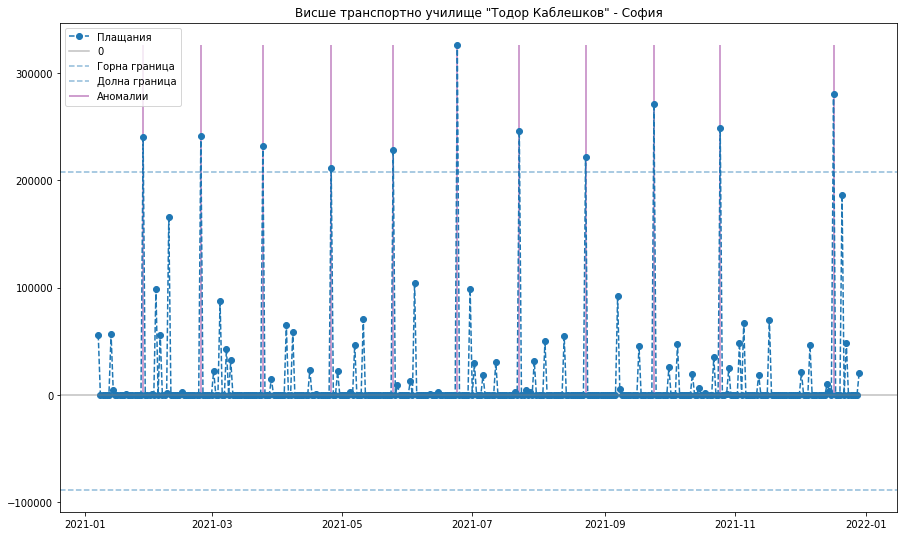

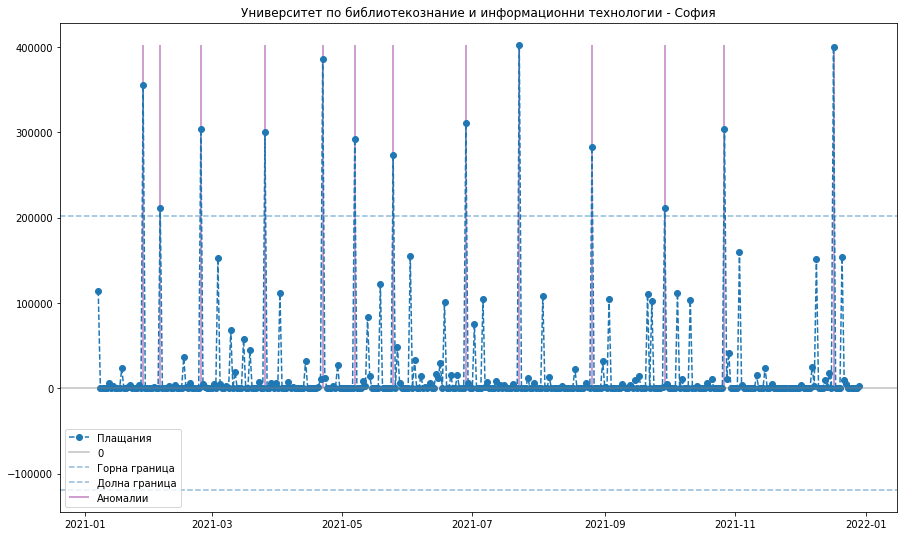

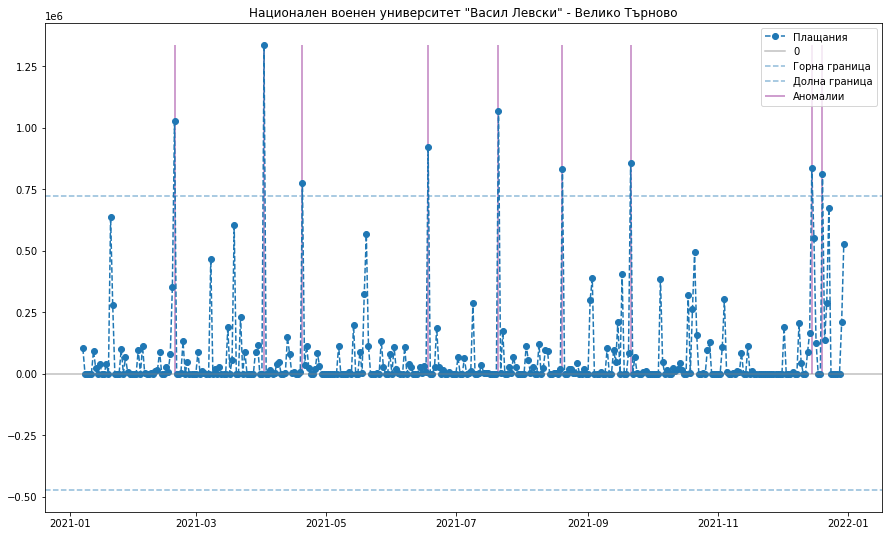

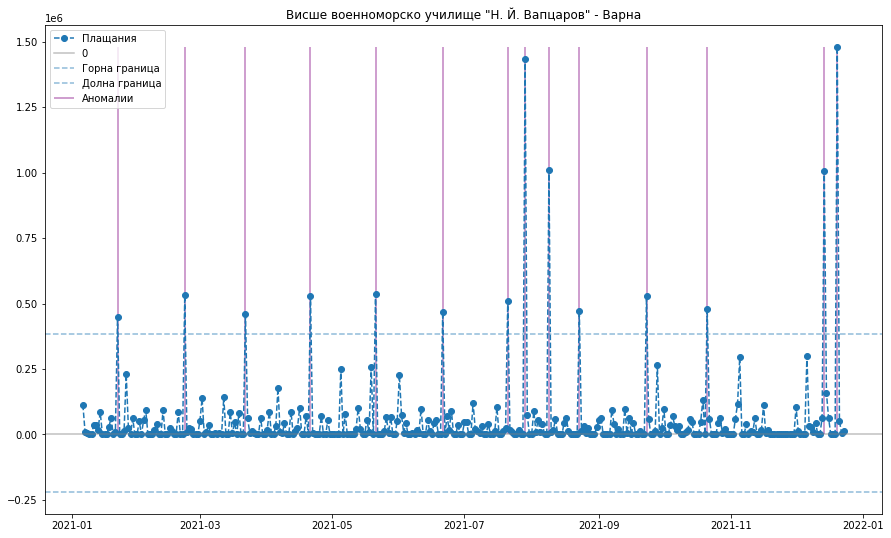

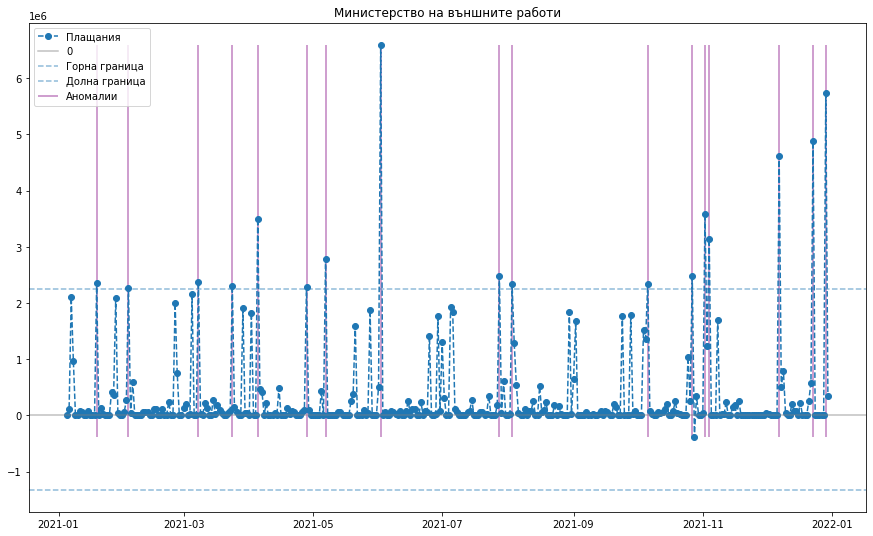

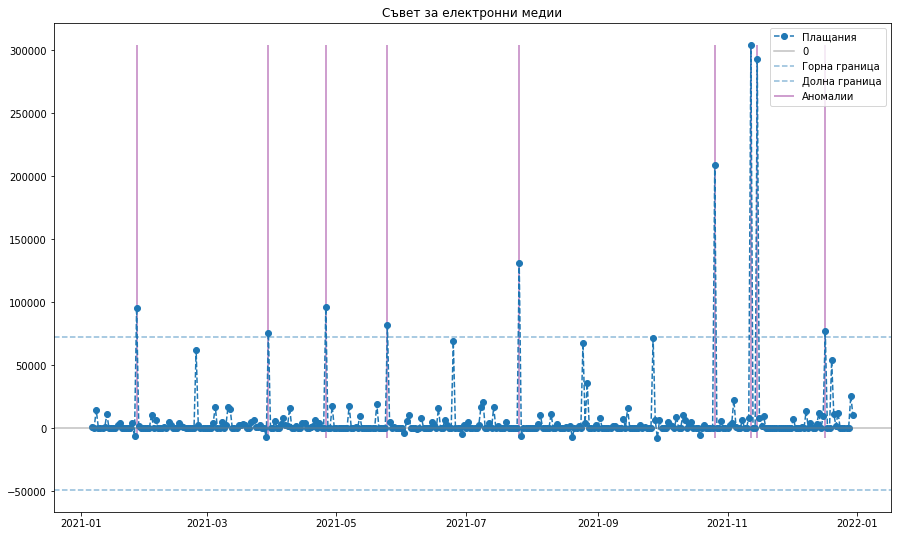

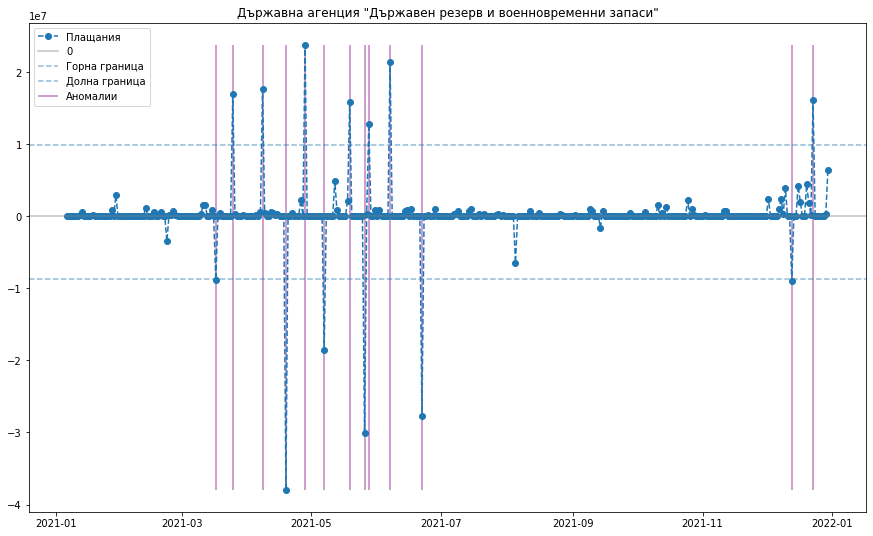

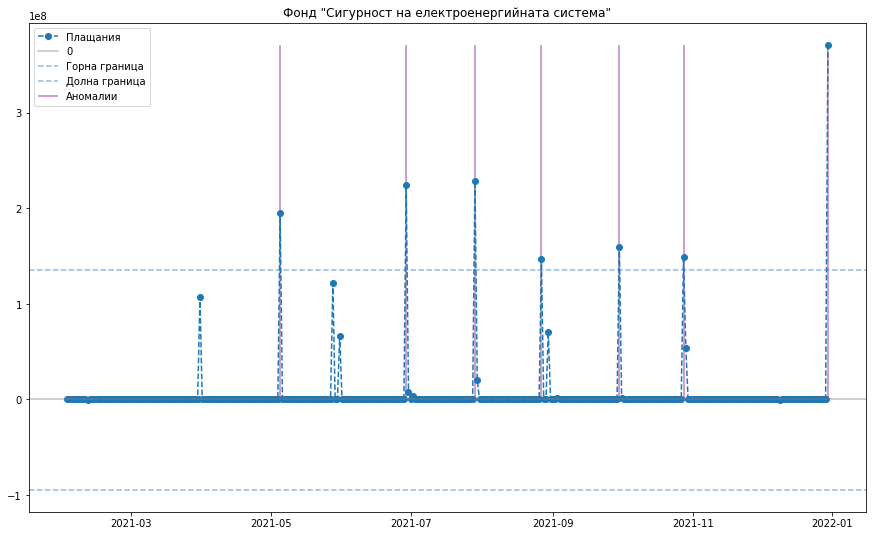

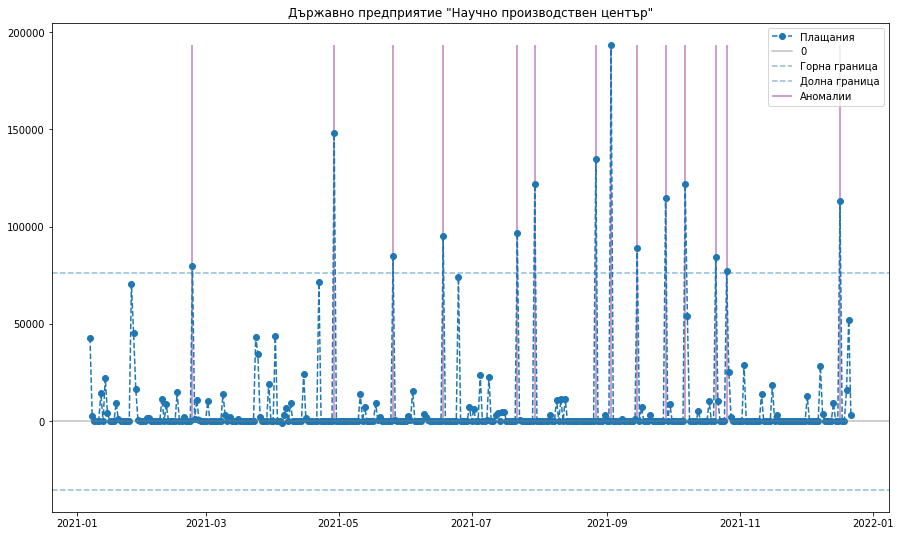

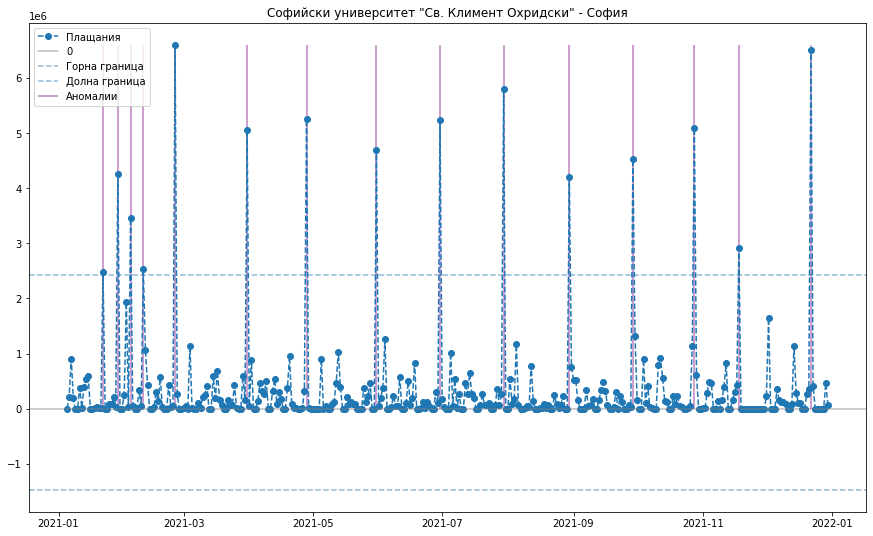

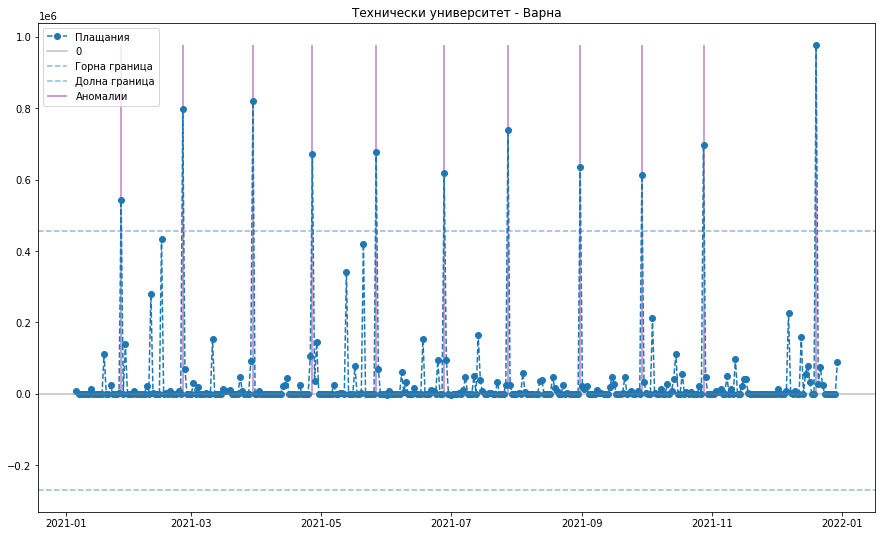

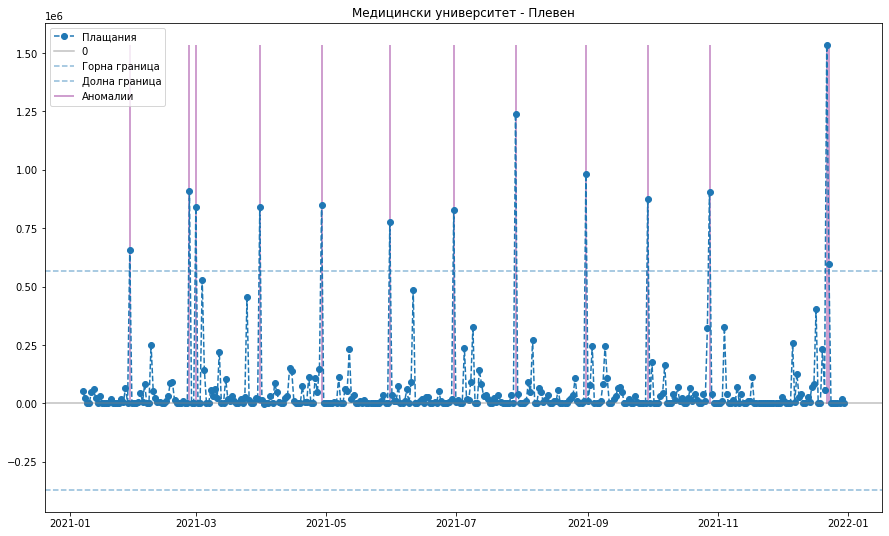

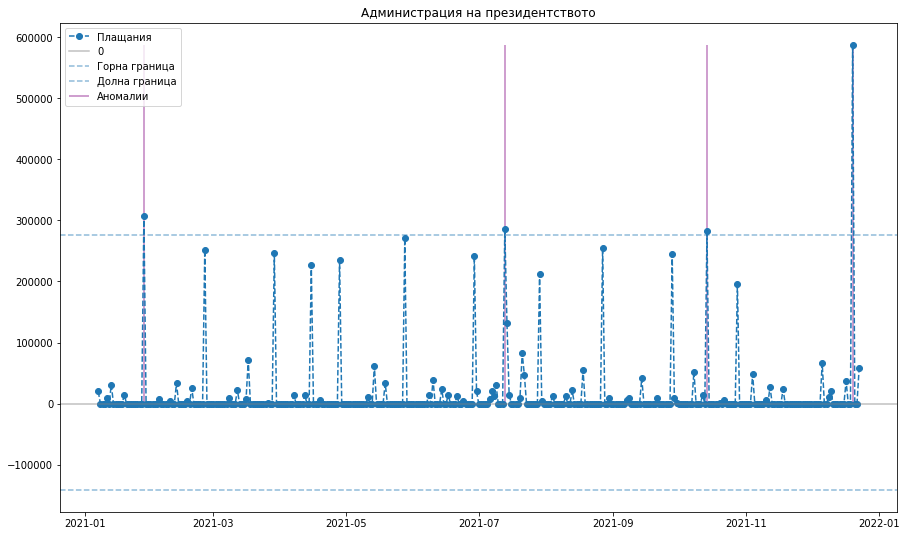

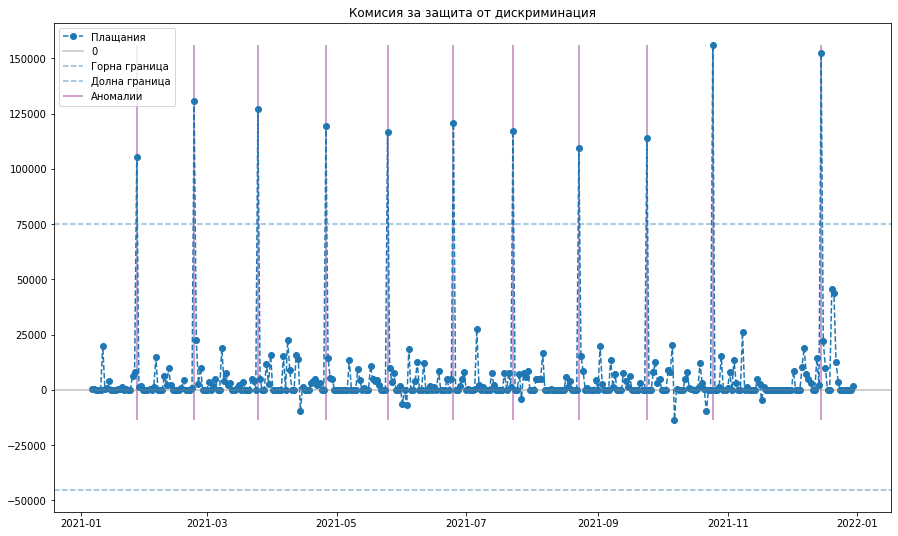

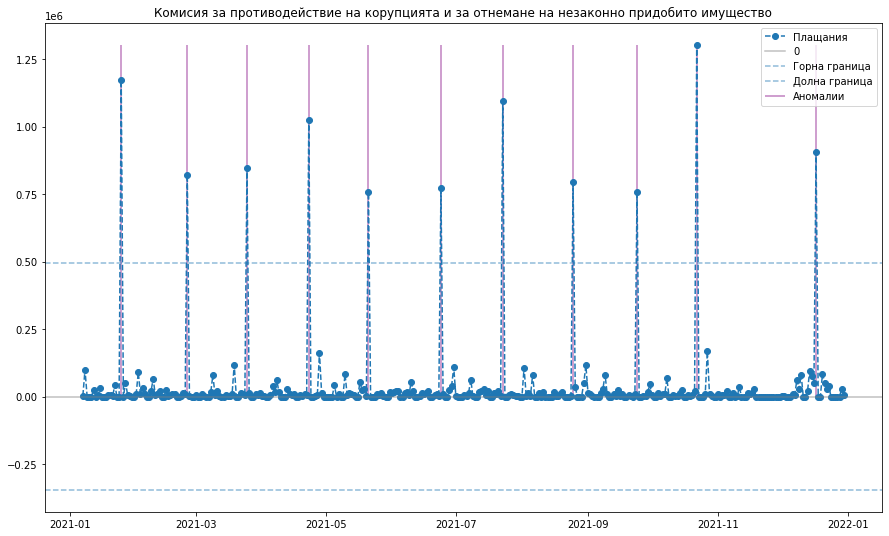

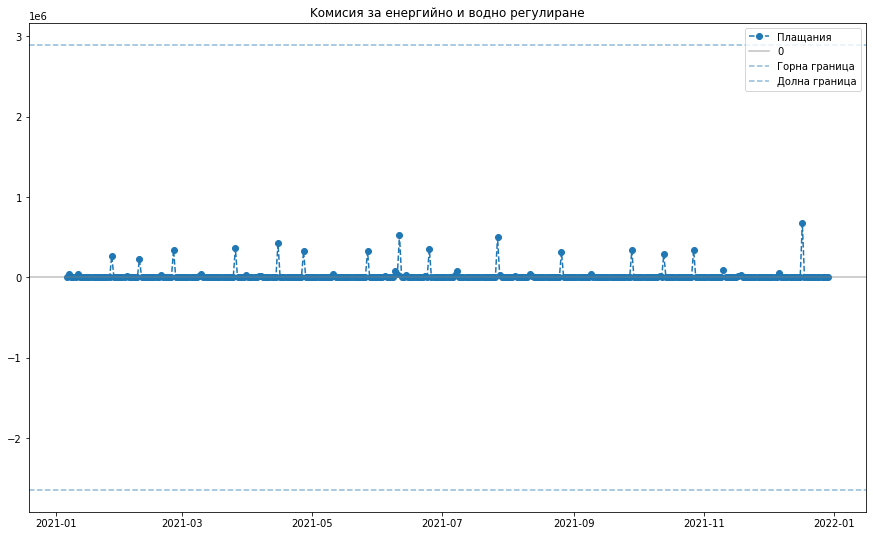

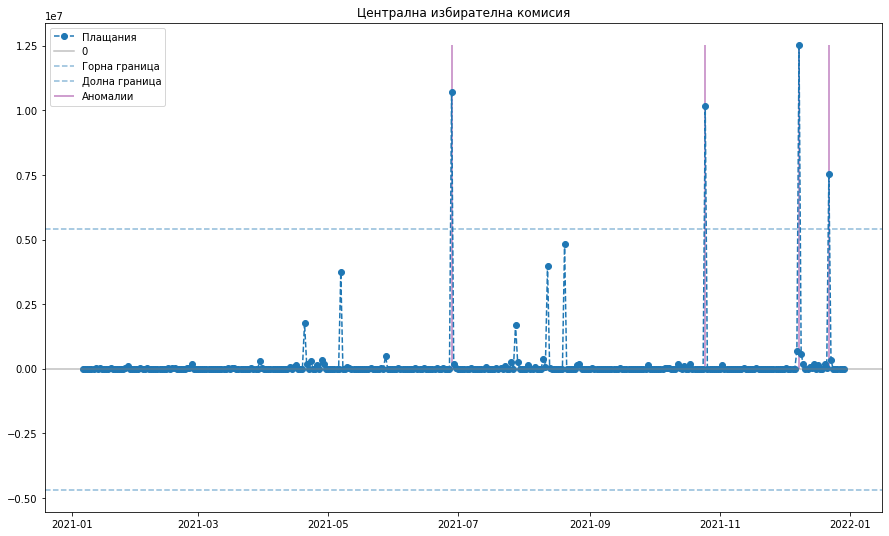

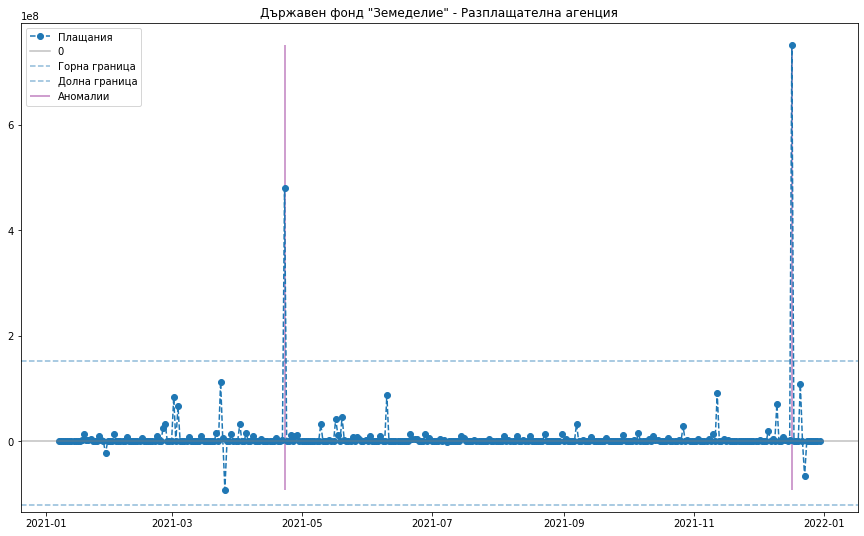

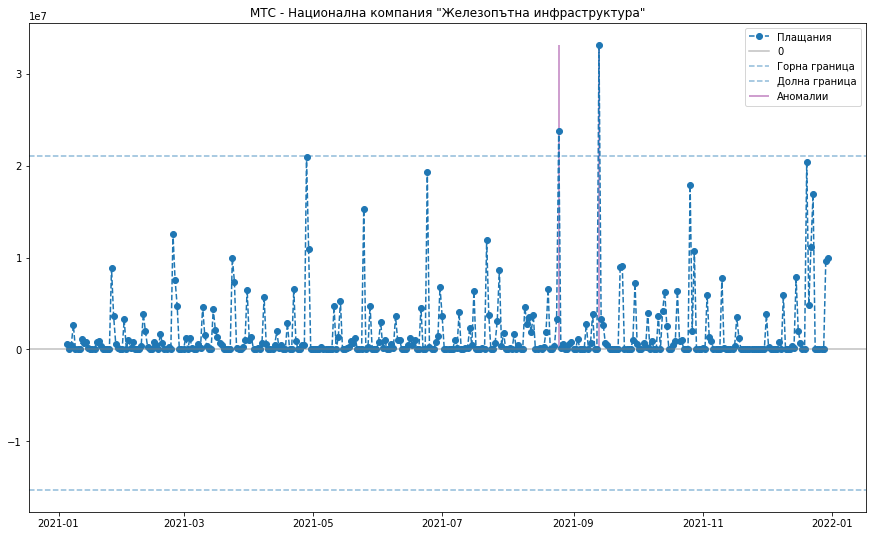

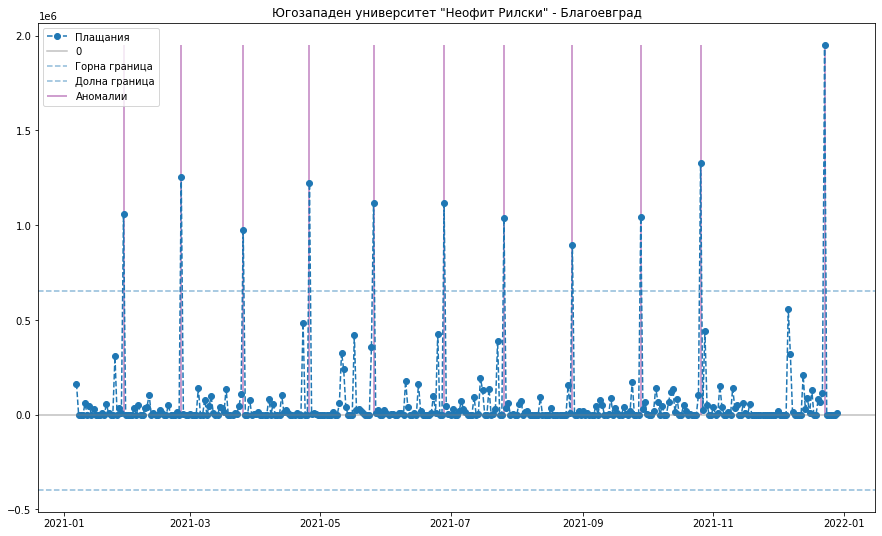

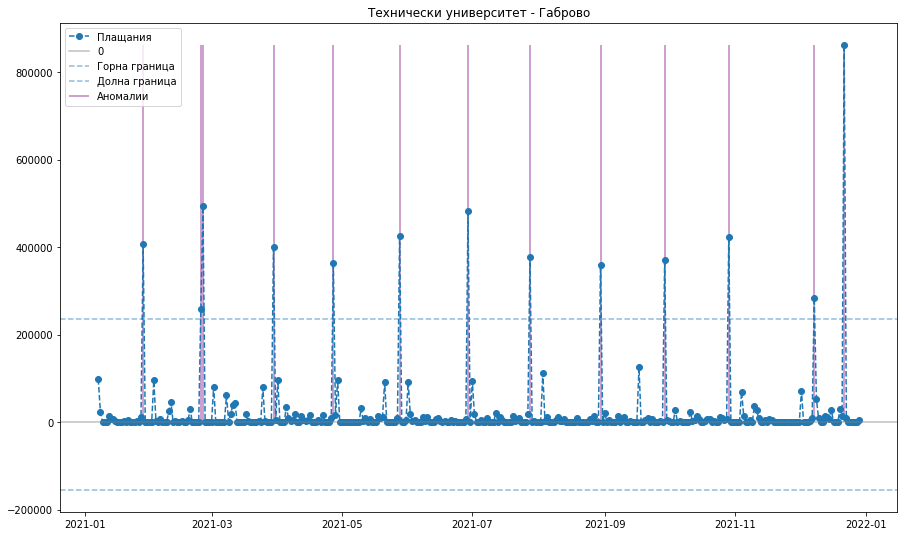

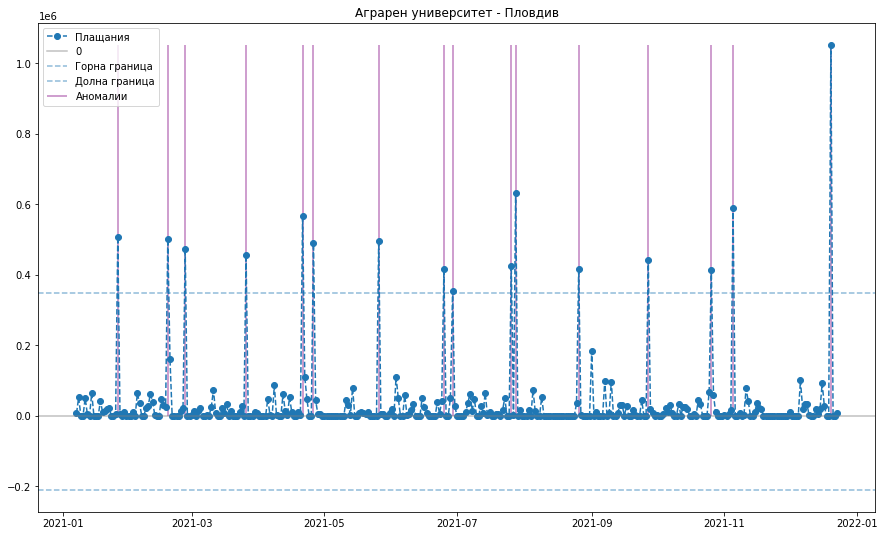

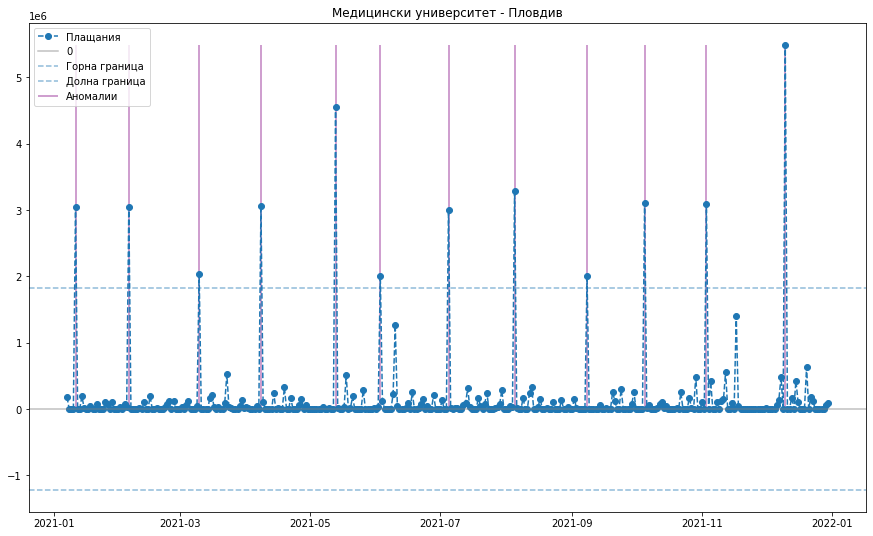

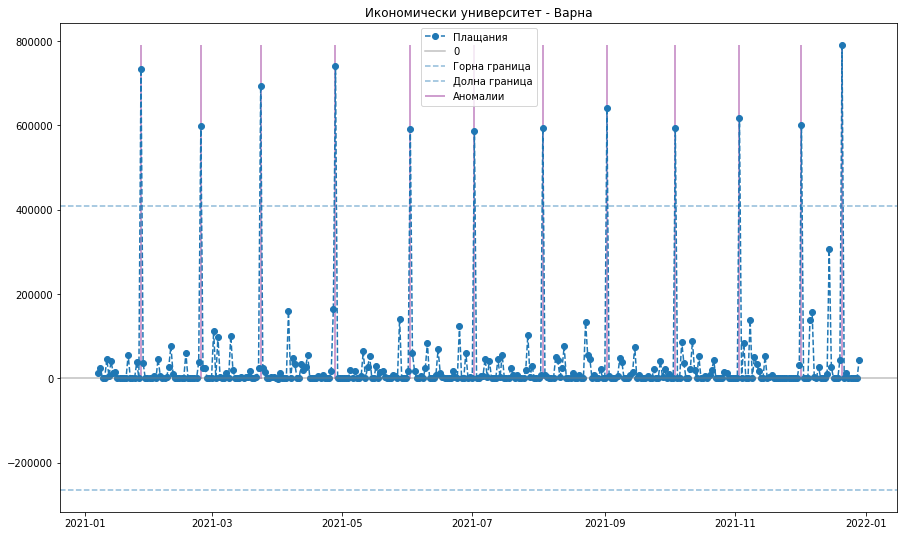

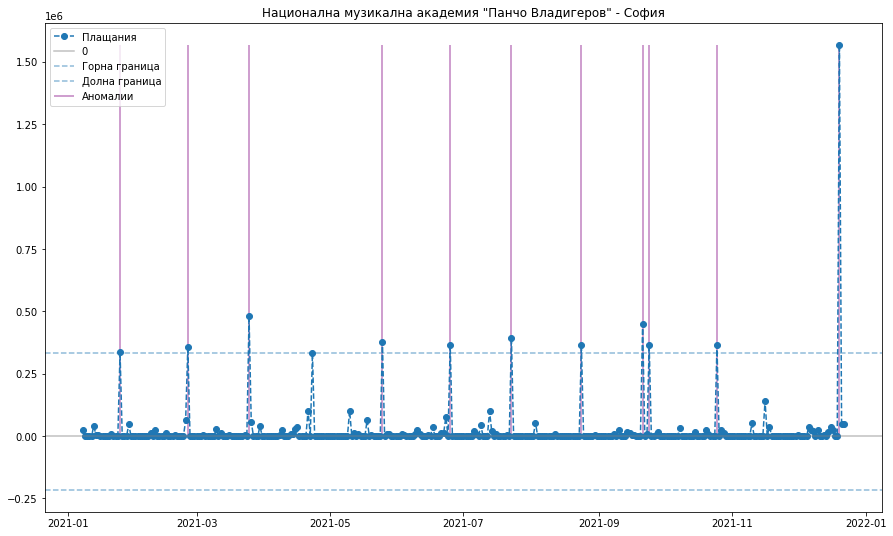

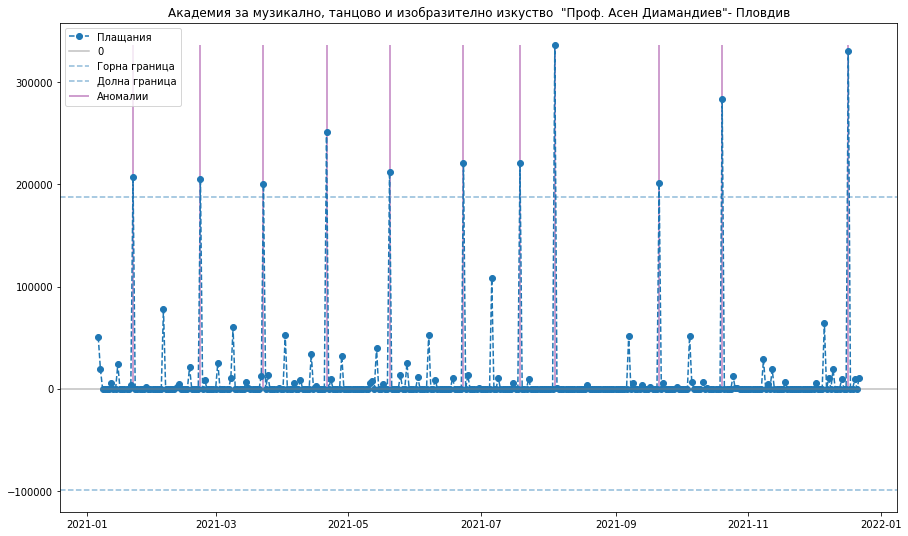

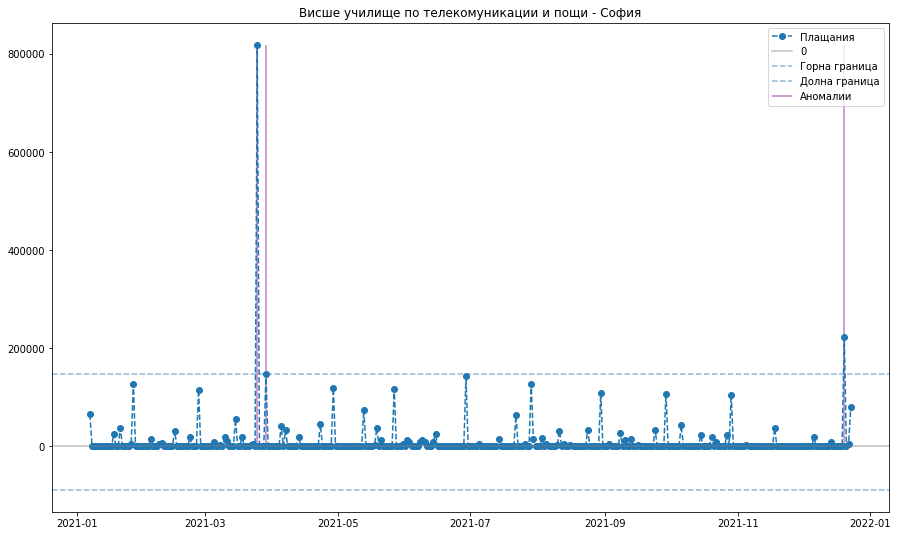

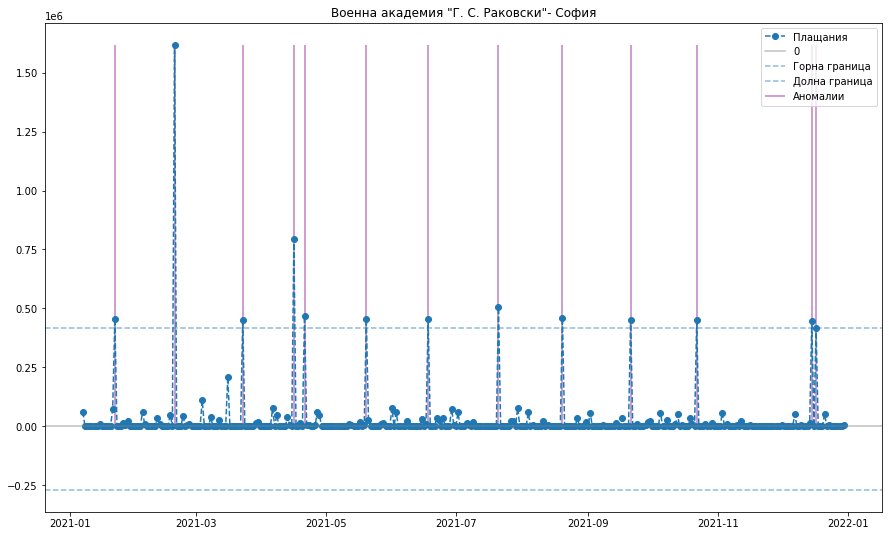

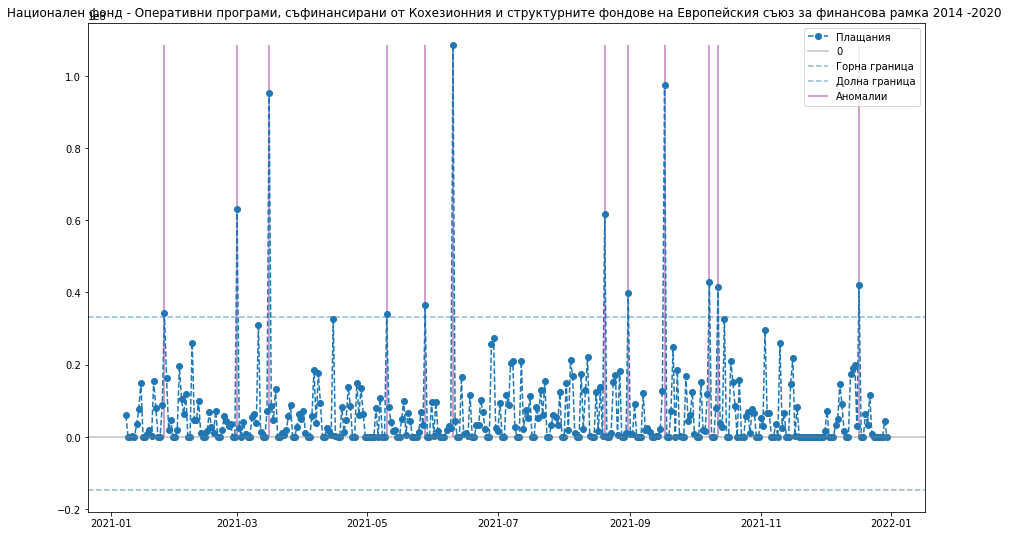

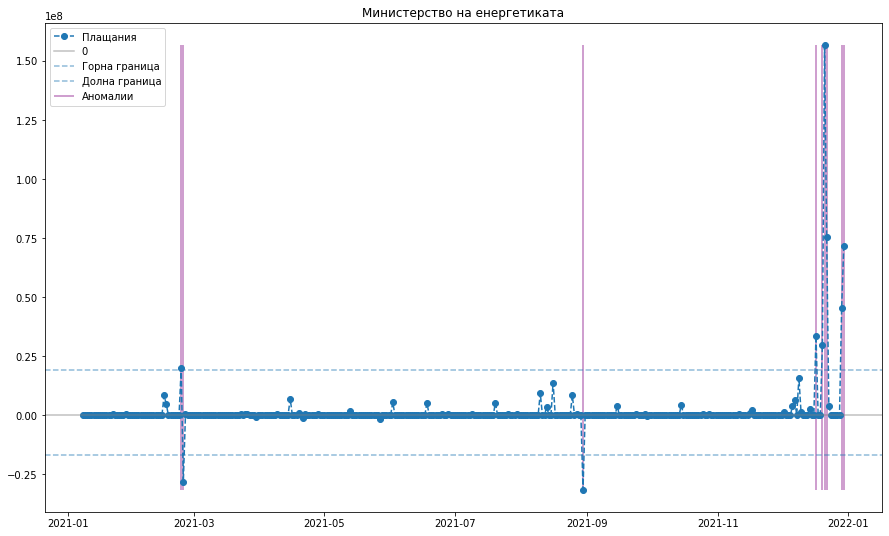

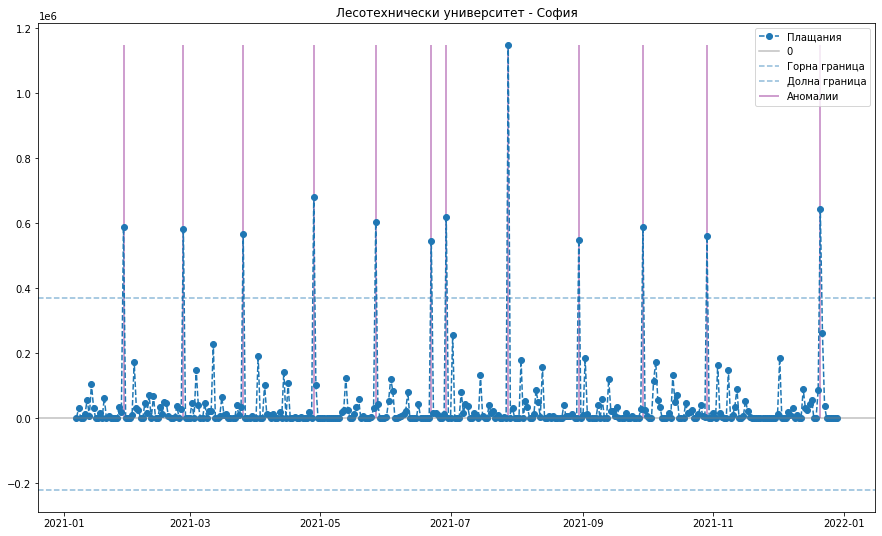

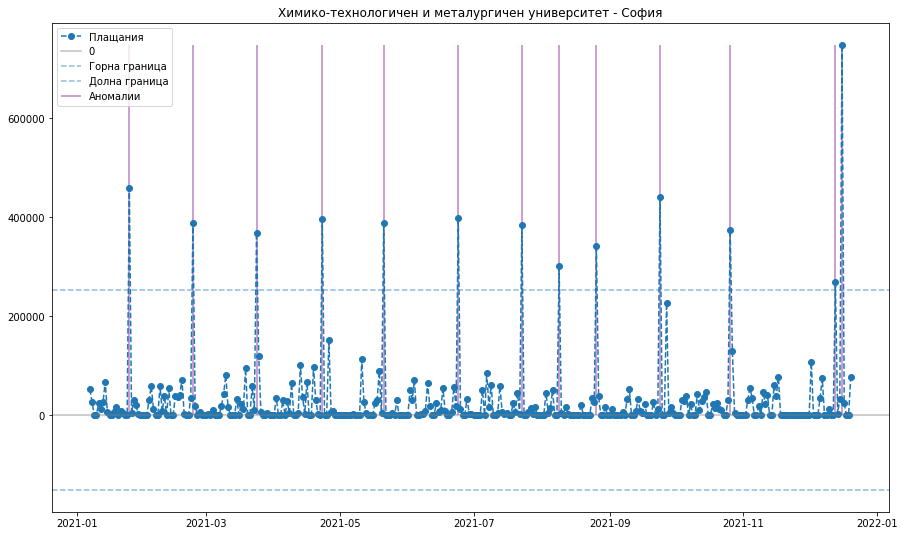

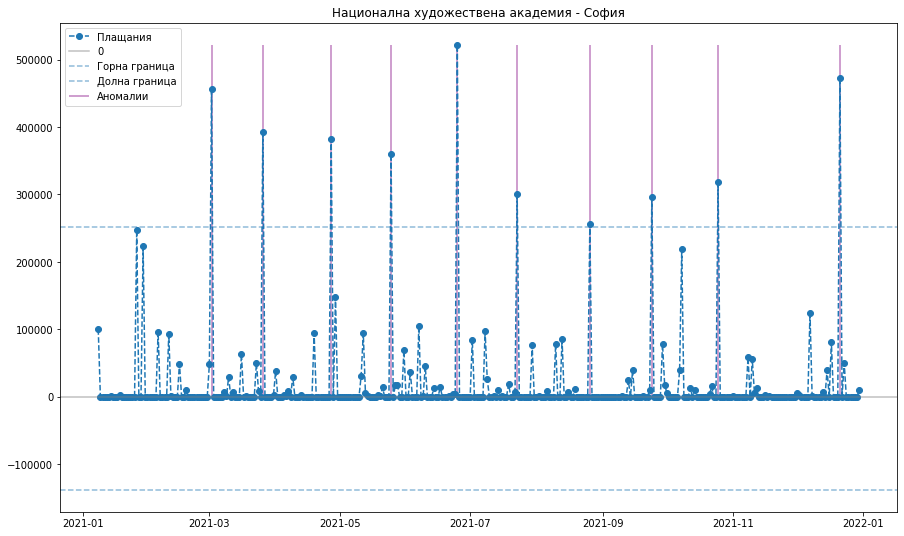

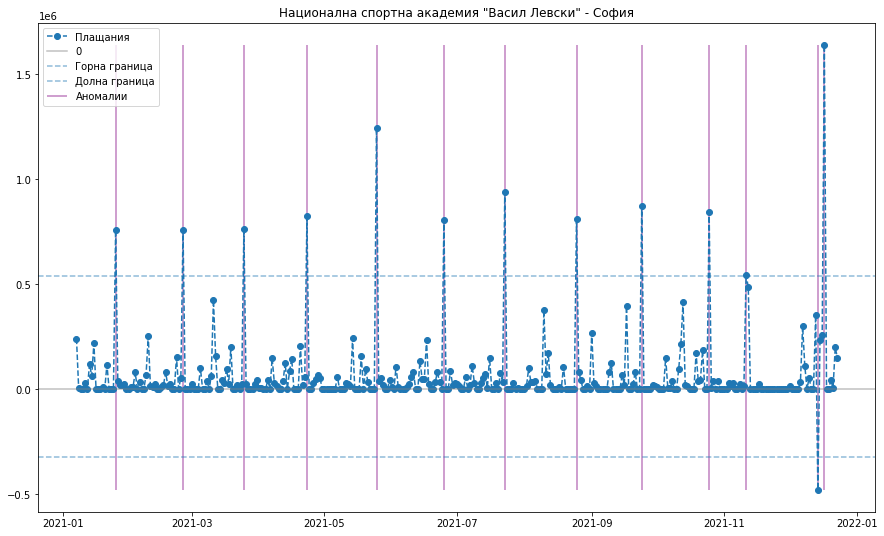

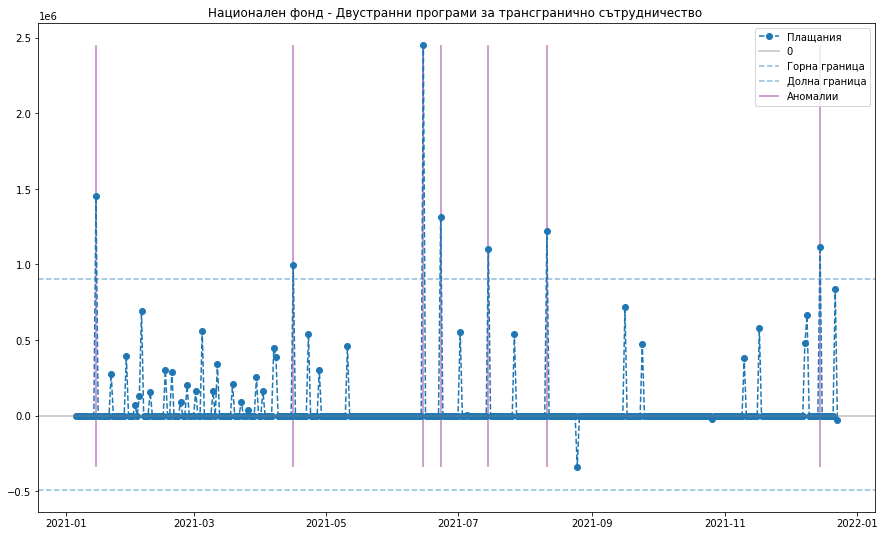

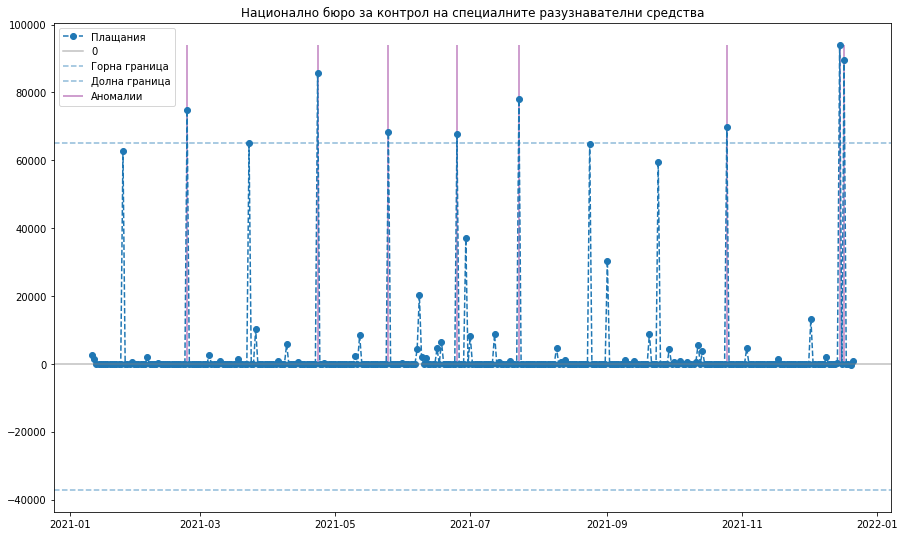

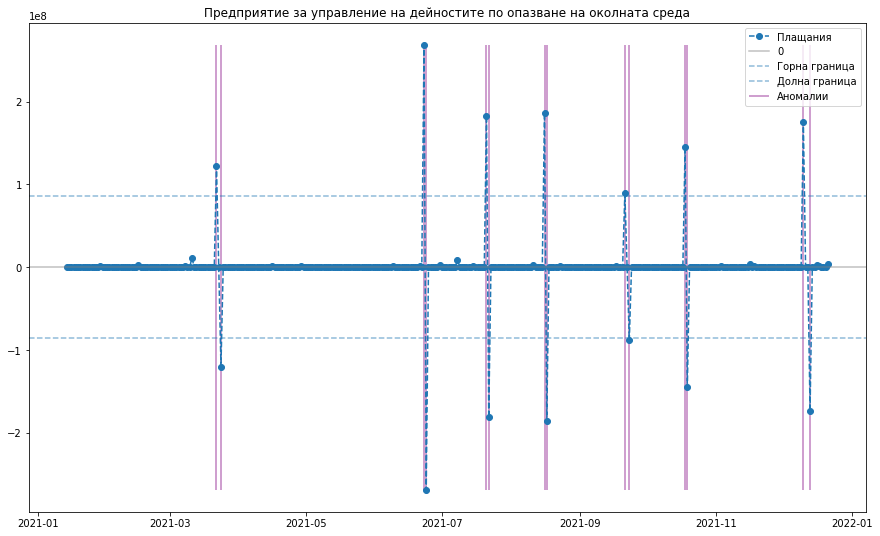

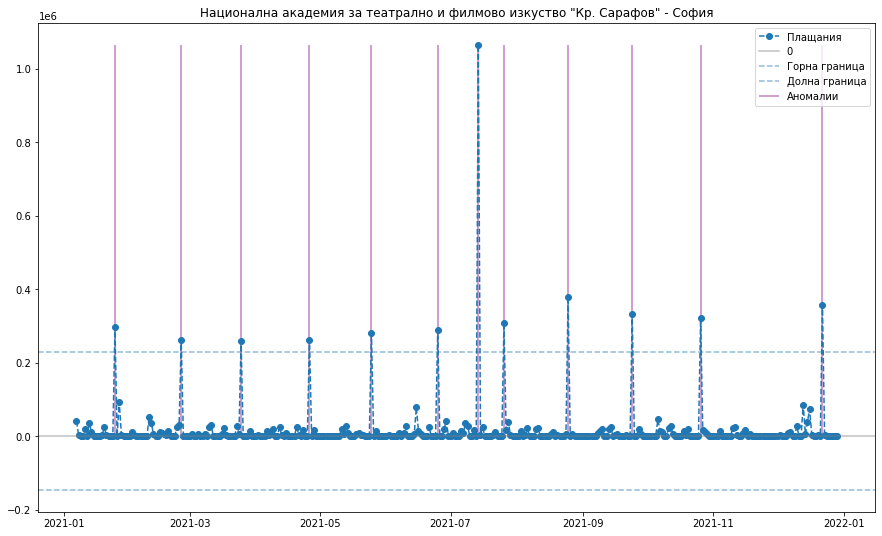

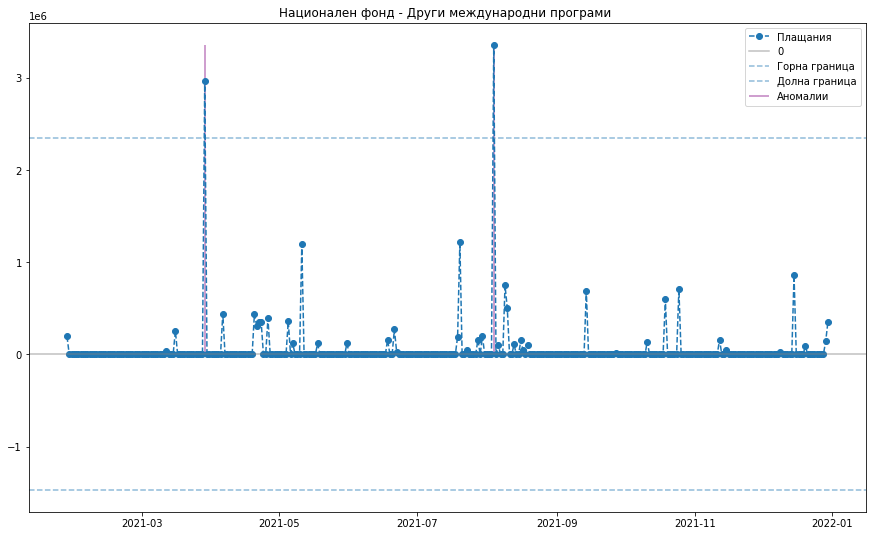

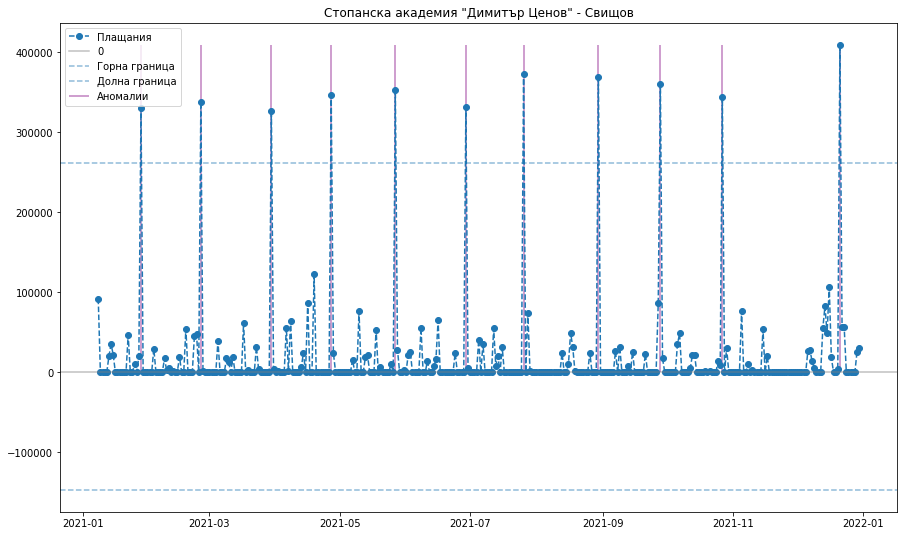

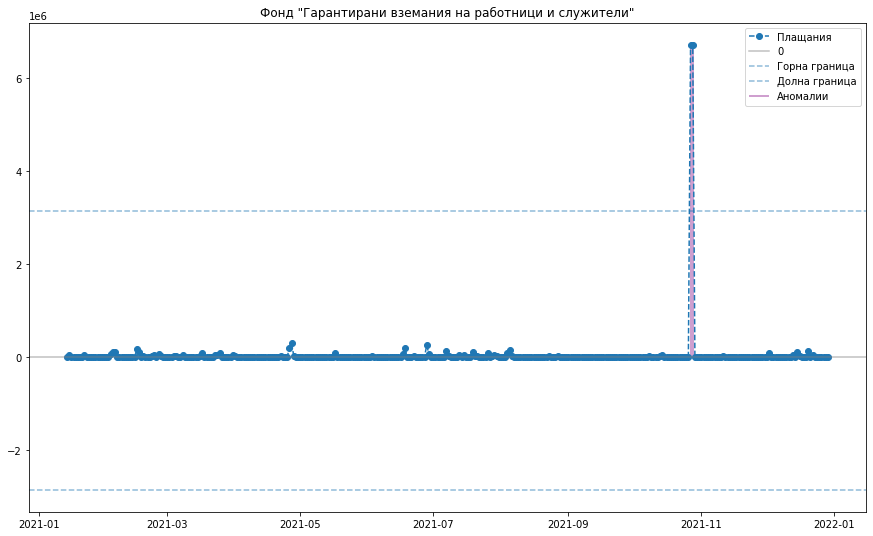

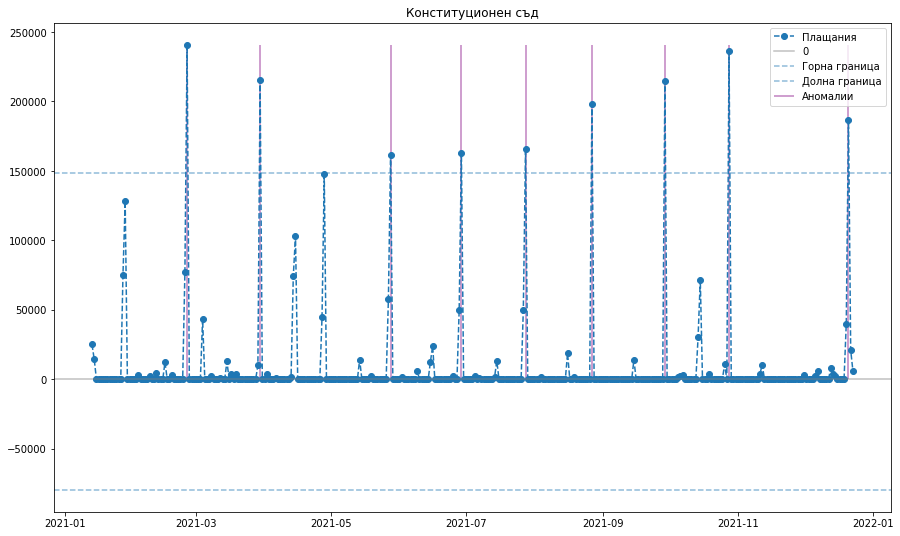

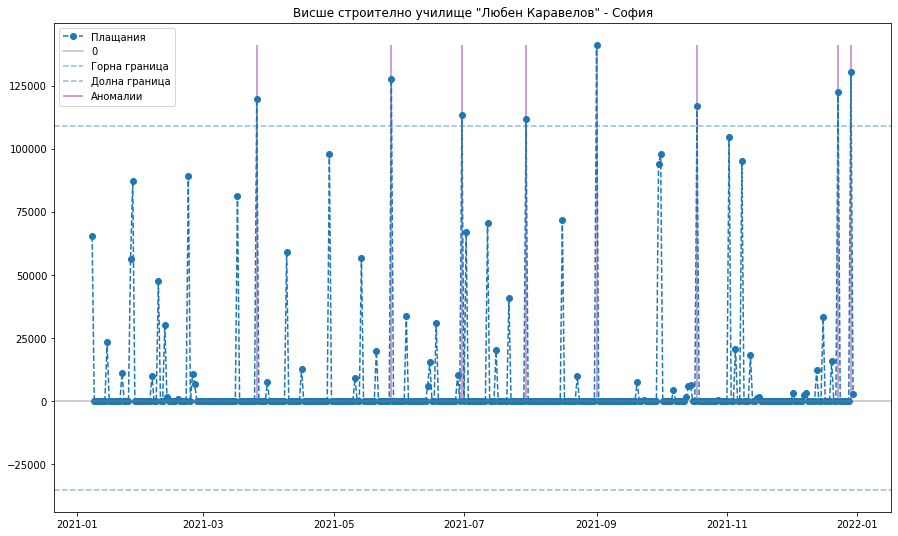

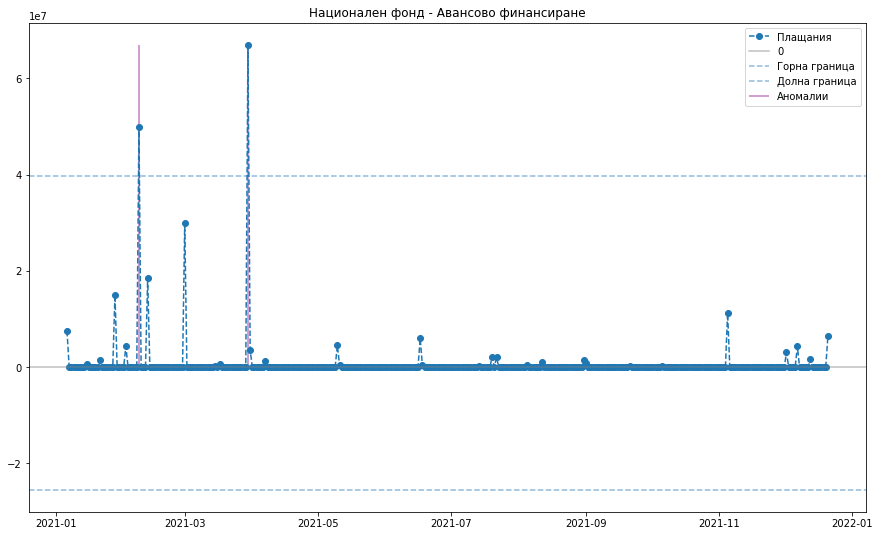

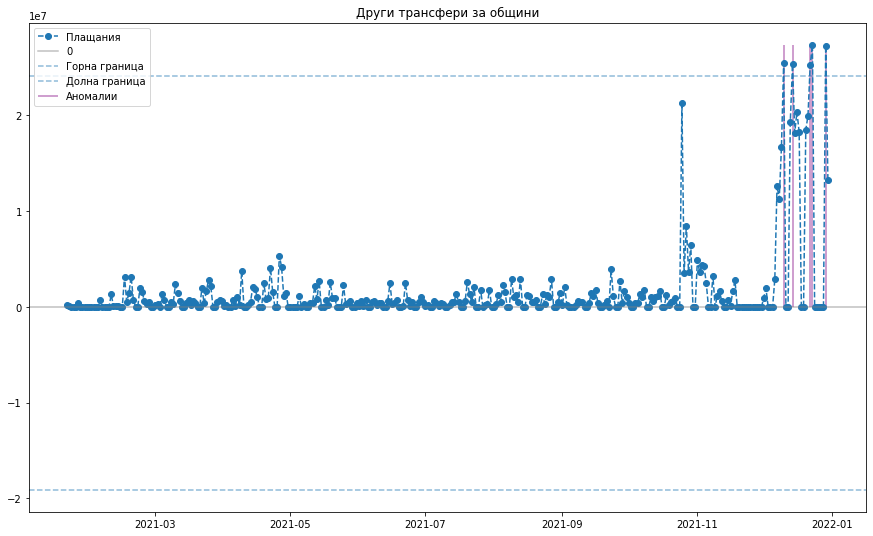

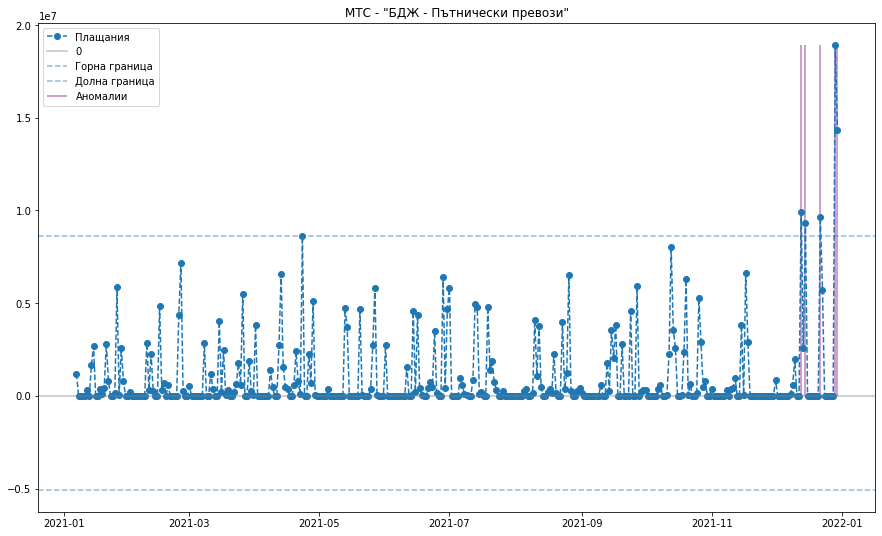

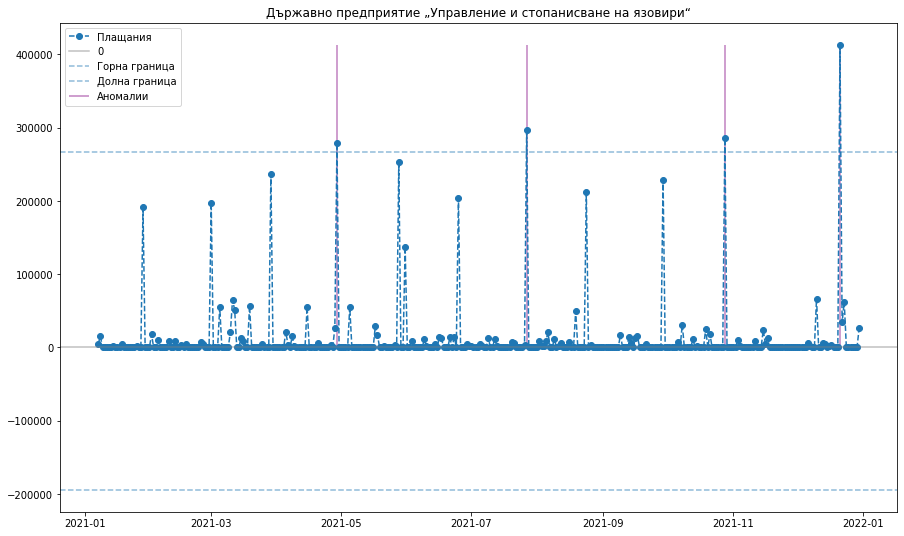

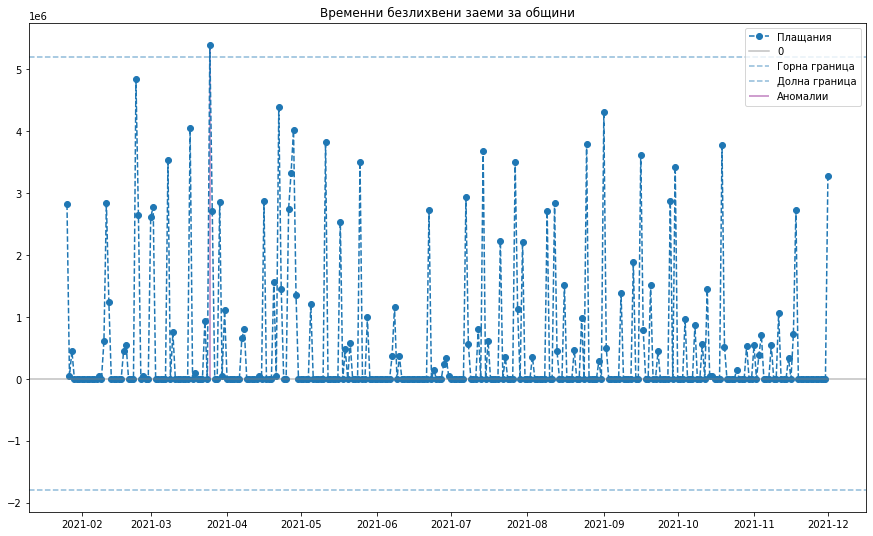

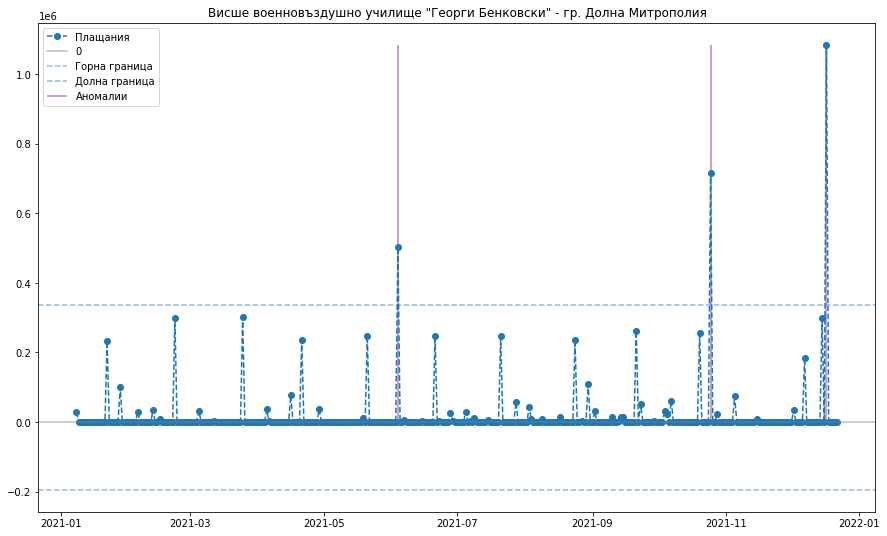

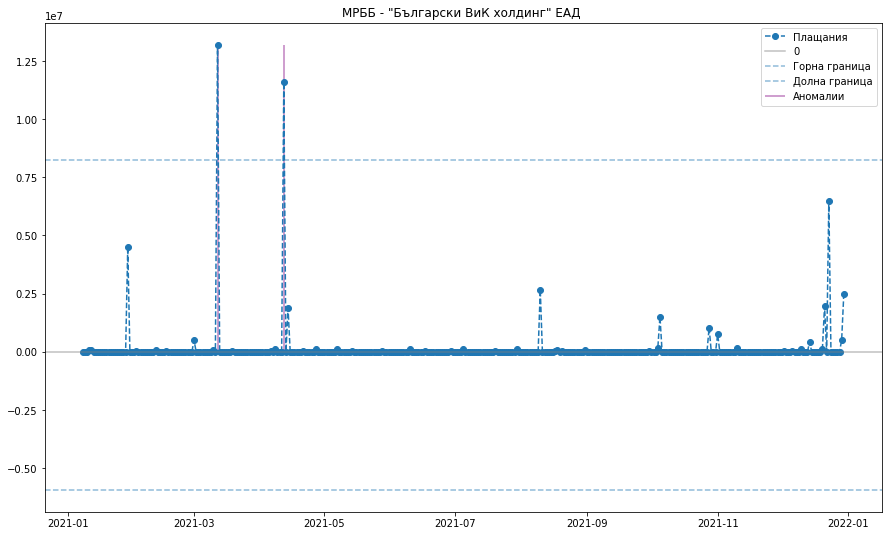

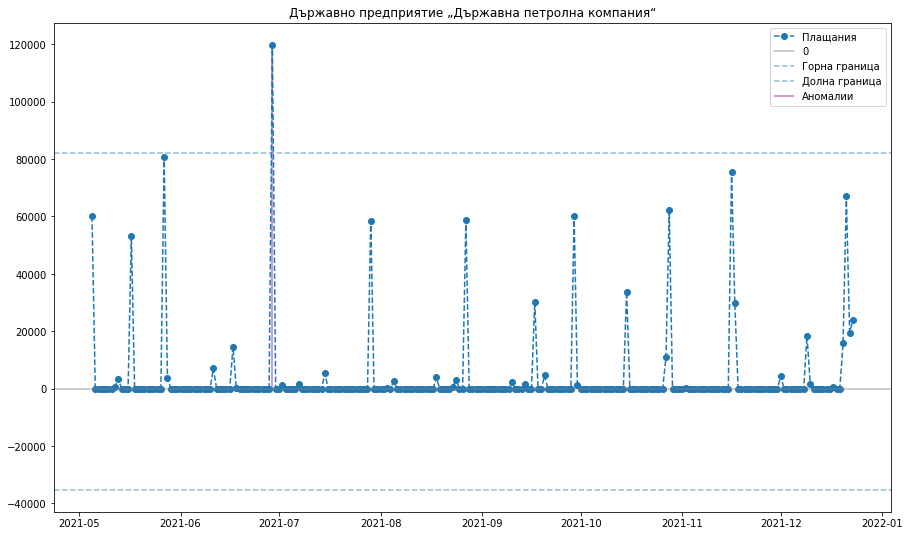

In [27]:
anomaly_choice_norm = 'anomaly_norm_nonzero'
# anomaly_choice_iqr = 'anomaly_iqr_nonzero' 

for org_id, org_name in id2name.items():
    org_payments = df_grouped_by_org[
        (df_grouped_by_org['Organization ID']==org_id) &
        (df_grouped_by_org['Start Date'] >= pd.Timestamp('2021-01-01')) &
        (df_grouped_by_org['Start Date'] < pd.Timestamp('2022-01-01'))
    ].copy() 
    anomalies_norm = org_payments[org_payments[anomaly_choice_norm]>0].copy()
#     anomalies_iqr = org_payments[org_payments[anomaly_choice_iqr]>0].copy()
    
    if org_payments.shape[0] > 0:
        date_fill_df = pd.DataFrame({
            'Start Date': pd.date_range(org_payments['Start Date'].min(), org_payments['Start Date'].max())
        })
        org_payments = date_fill_df.merge(org_payments, on='Start Date', how='left')
        org_payments['Operations Amount (BGN)'].fillna(0, inplace=True)
        min_pay = org_payments['Operations Amount (BGN)'].min()
        max_pay = org_payments['Operations Amount (BGN)'].max()
        
        labels = ["Плащания", 0]
        
        plt.figure(figsize=(15, 9))
        plt.plot(org_payments['Start Date'], org_payments['Operations Amount (BGN)'], marker="o", linestyle="dashed")
        plt.vlines(anomalies_norm['Start Date'], min_pay, max_pay, colors='purple', alpha=0.5)
        plt.axhline(y=0, c='grey', alpha=0.5)
        
        if id2stats[org_id]!={}:
            plt.axhline(y=id2stats[org_id]['nonzero']['norm_high'], c='tab:blue', linestyle="--", alpha=0.5)
            plt.axhline(y=id2stats[org_id]['nonzero']['norm_low'], c='tab:blue', linestyle="--", alpha=0.5)
            labels.append('Горна граница')
            labels.append('Долна граница')
        
        
        if anomalies_norm.shape[0] > 0:
            labels.append("Аномалии")
            
        plt.legend(labels)
        plt.title(f"{org_name}")
        plt.show()

## Classify data points by Operations Code

In [14]:
df_grouped_by_op['anomaly_norm_nonzero'] = df_grouped_by_op.apply(
    lambda row: if_code_id(row, 'nonzero', classify_payments_norm),
    axis=1
)
df_grouped_by_op['anomaly_norm_zerofilled'] = df_grouped_by_op.apply(
    lambda row: if_code_id(row, 'zerofilled', classify_payments_norm),
    axis=1
)
df_grouped_by_op['anomaly_iqr_nonzero'] = df_grouped_by_op.apply(
    lambda row: if_code_id(row, 'nonzero', classify_payments_iqr),
    axis=1
)
df_grouped_by_op['anomaly_iqr_zerofilled'] = df_grouped_by_op.apply(
    lambda row: if_code_id(row, 'zerofilled', classify_payments_iqr),
    axis=1
)

np.around(100*df_grouped_by_op[
    [c for c in df_grouped_by_op.columns if "anomaly" in c]
].sum()/df_grouped_by_op.shape[0], 2)

anomaly_norm_nonzero        3.05
anomaly_norm_zerofilled     4.63
anomaly_iqr_nonzero        11.60
anomaly_iqr_zerofilled     25.18
dtype: float64

In [15]:
code2operation[code]

'Средства на разпореждане'

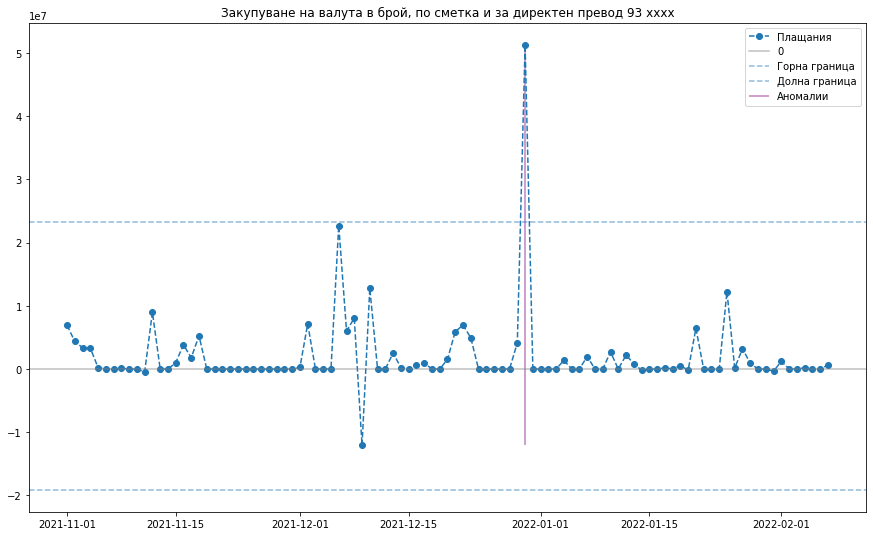

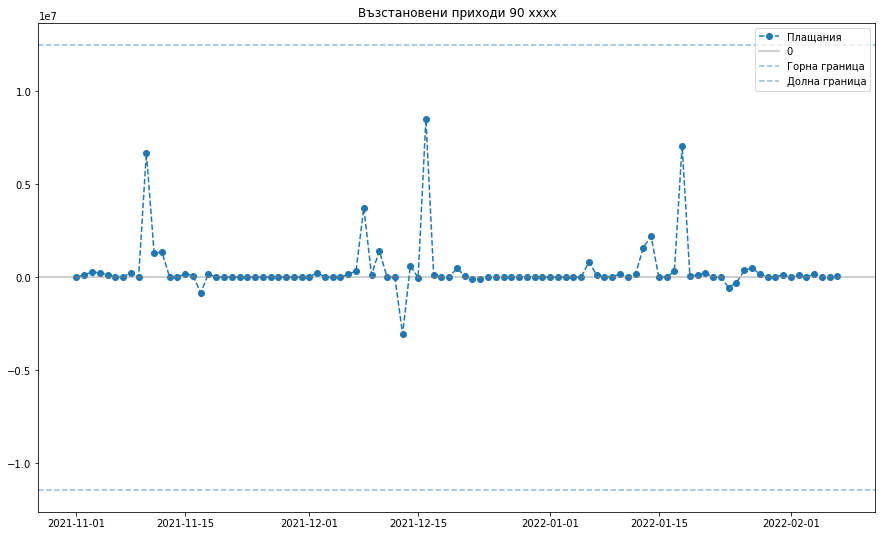

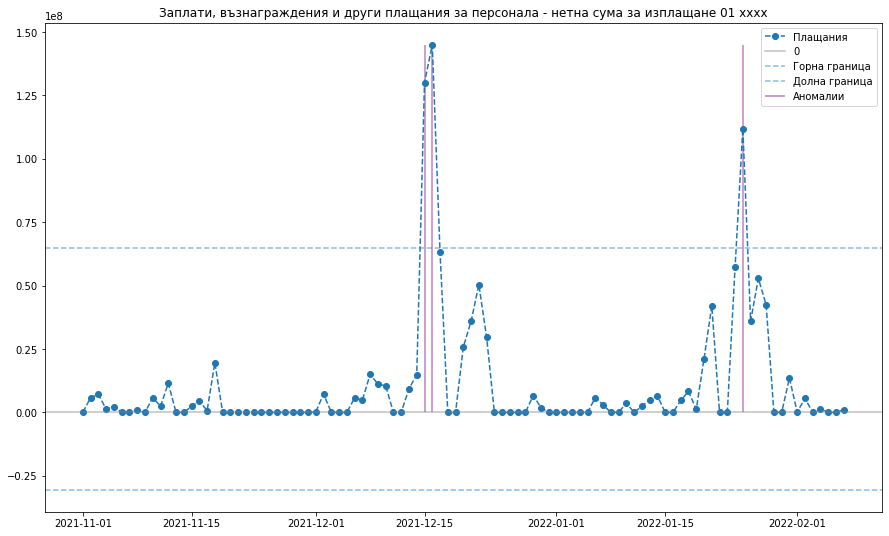

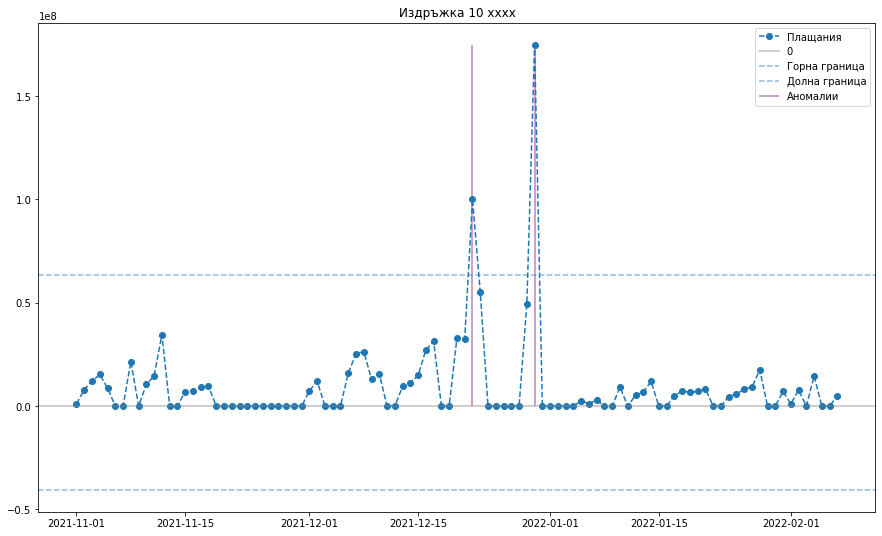

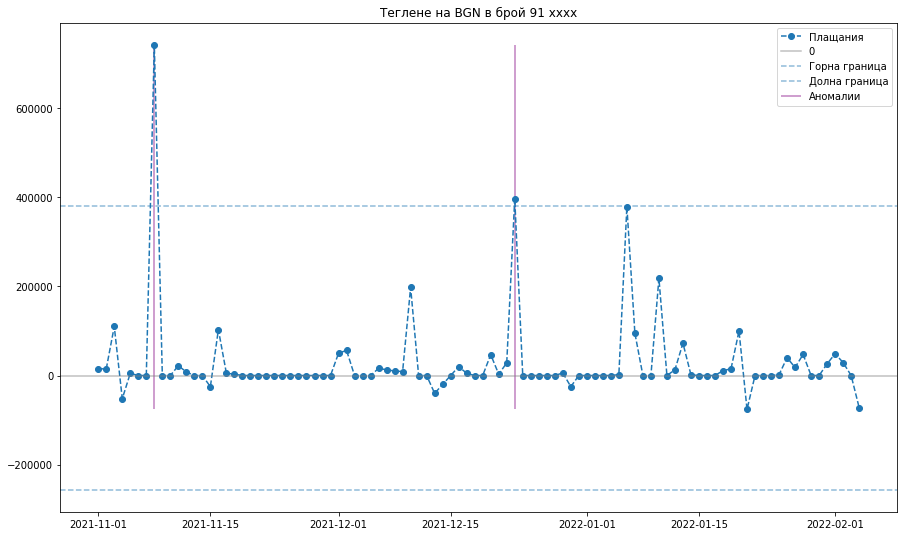

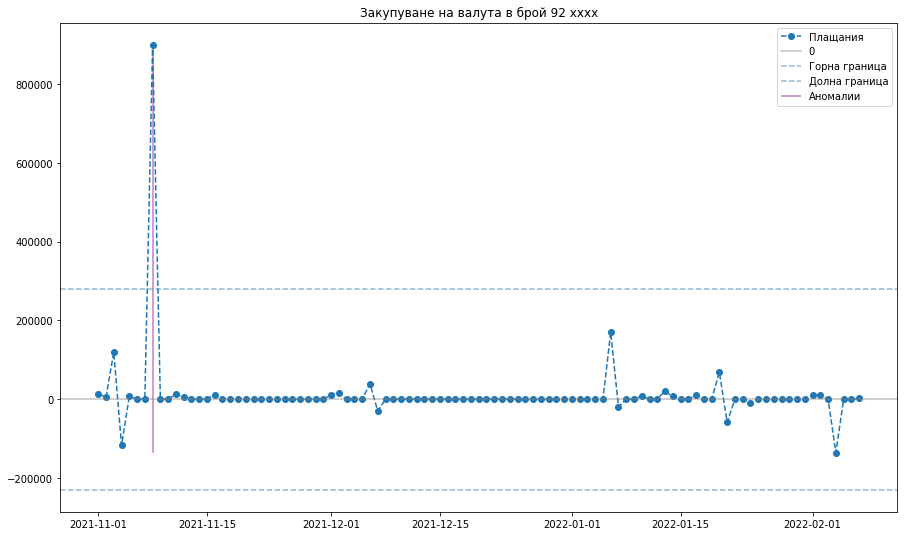

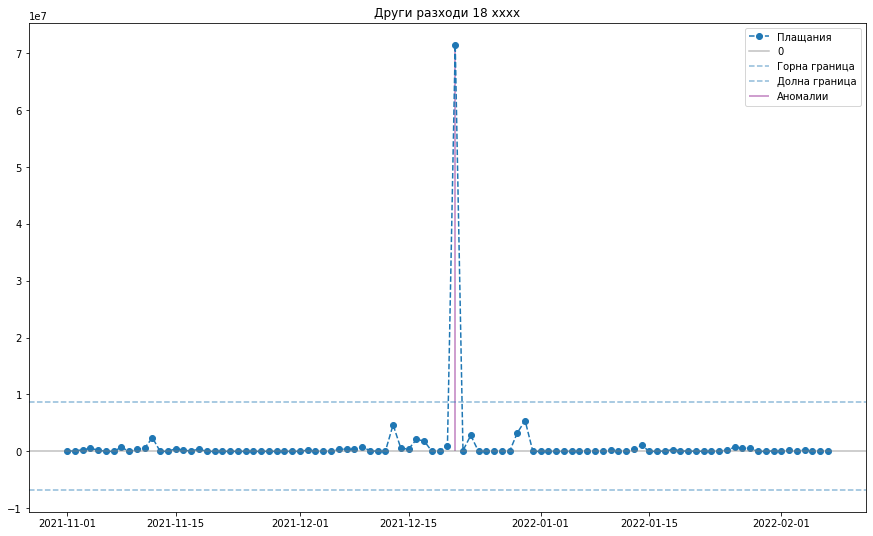

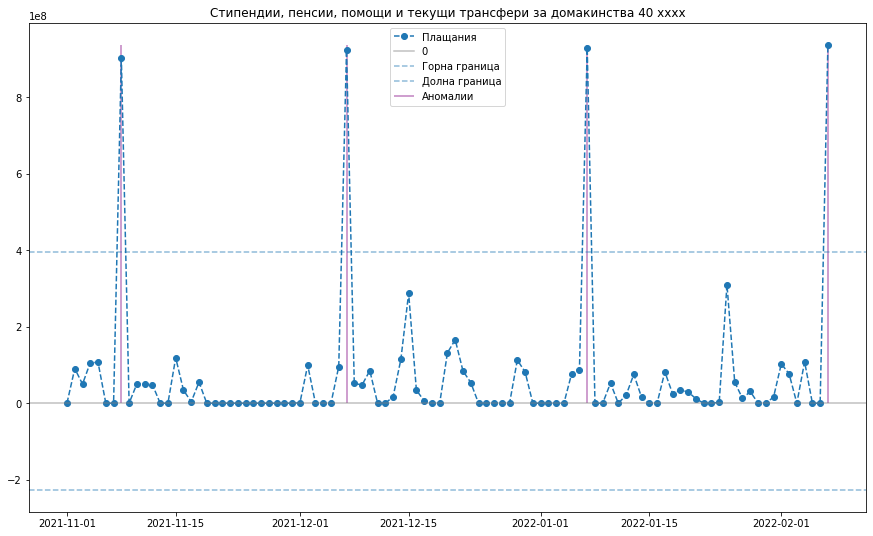

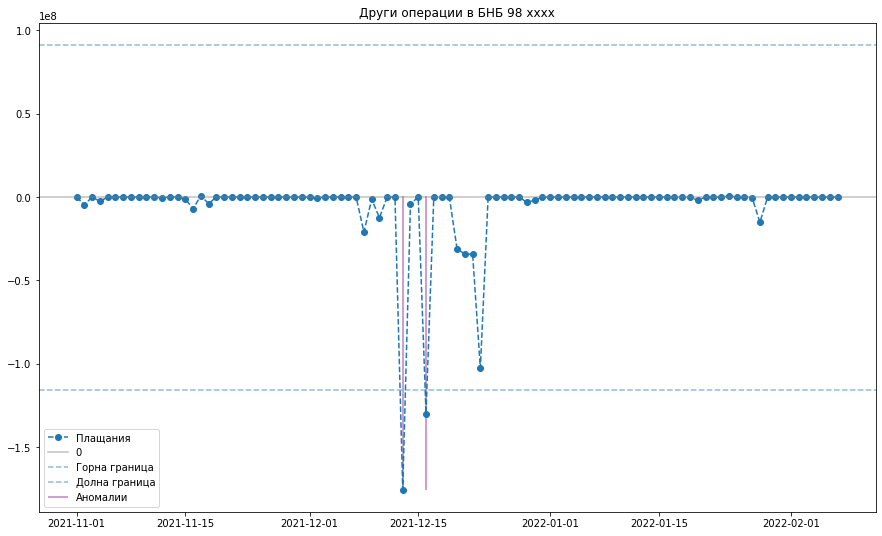

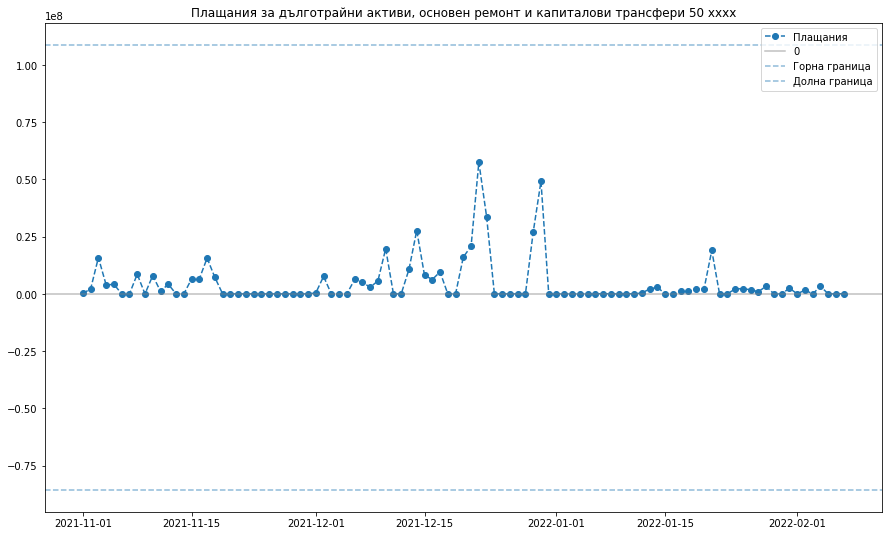

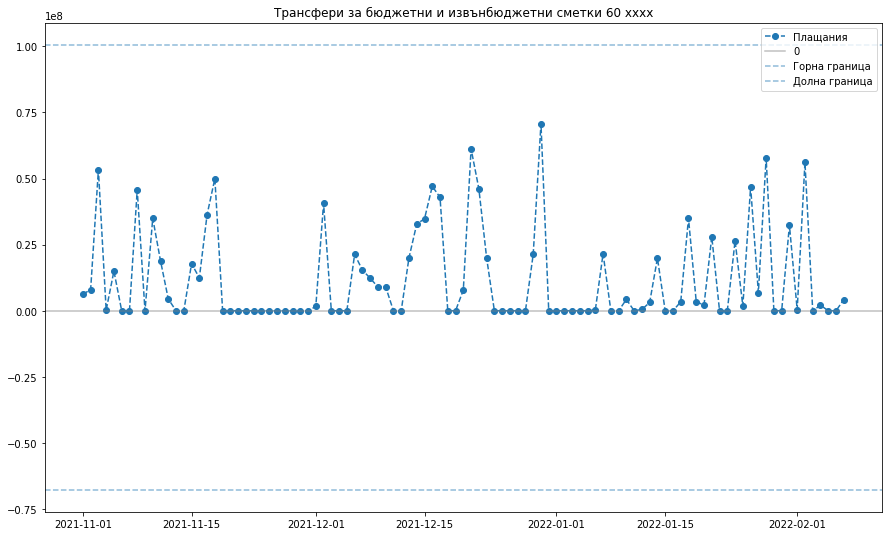

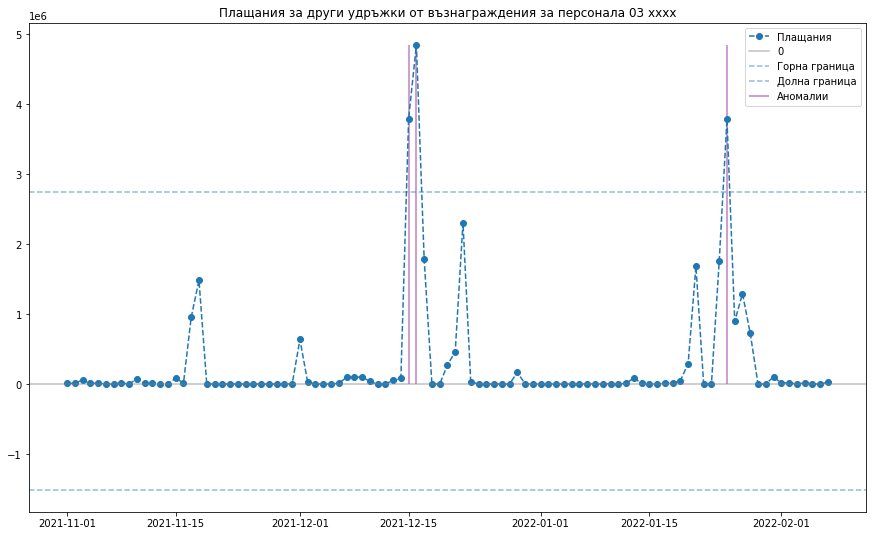

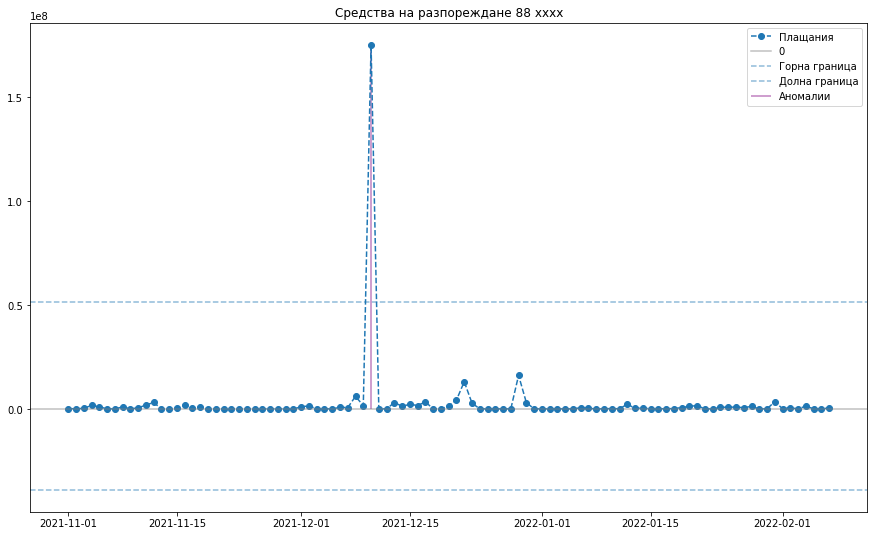

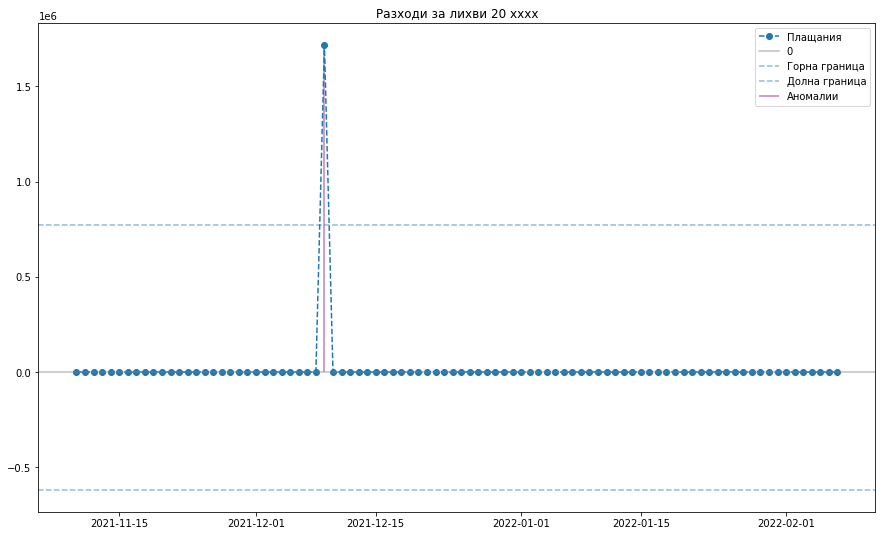

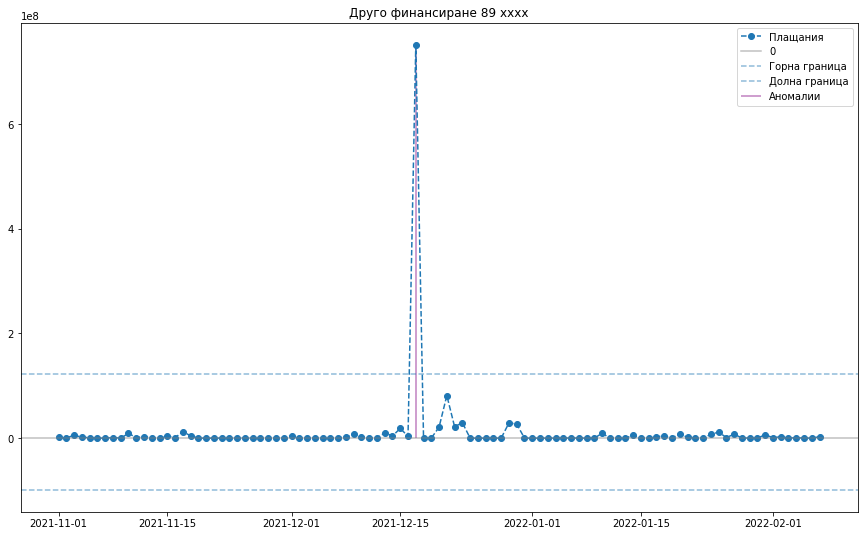

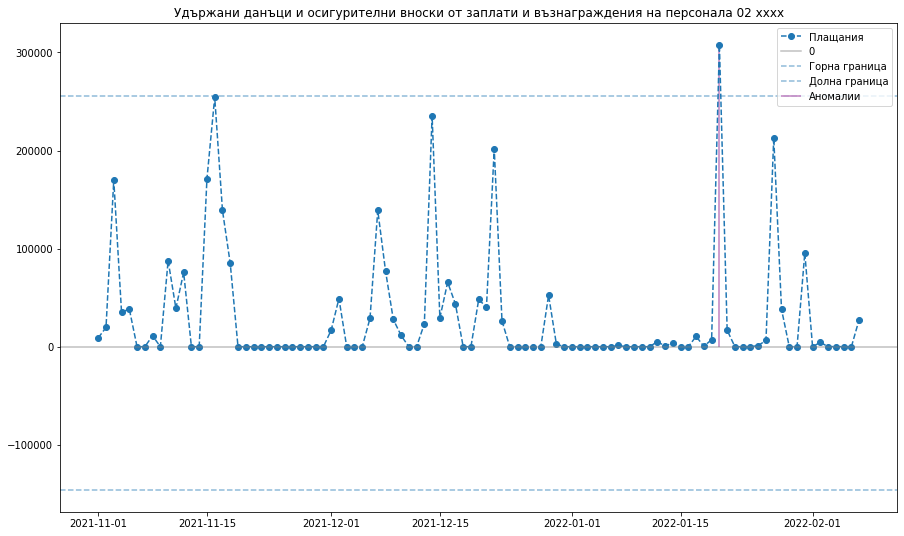

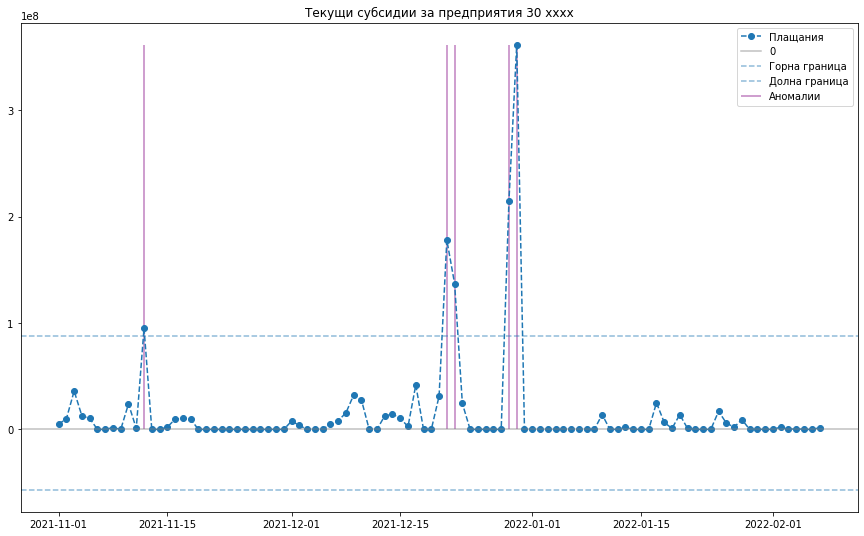

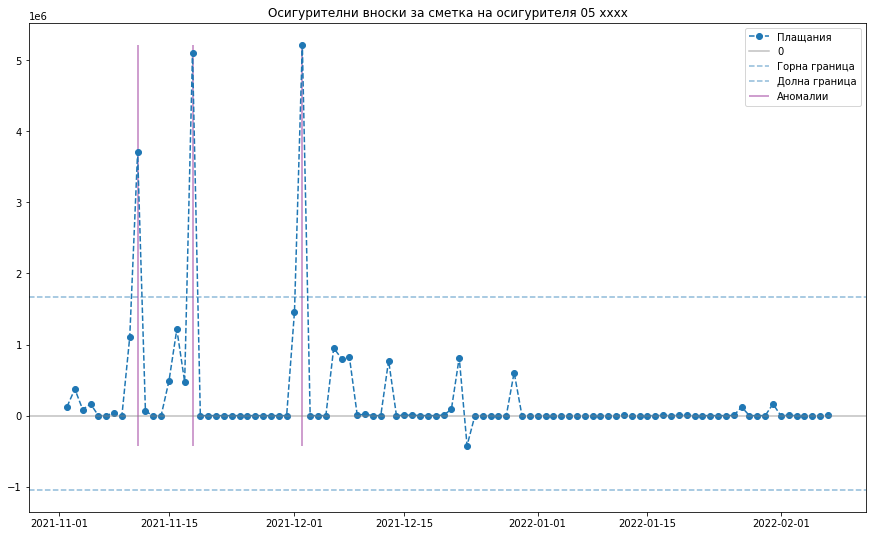

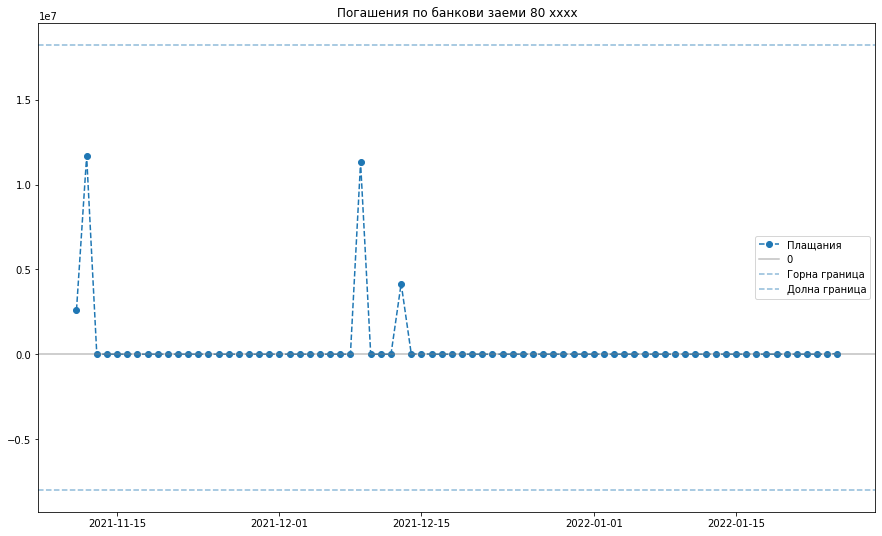

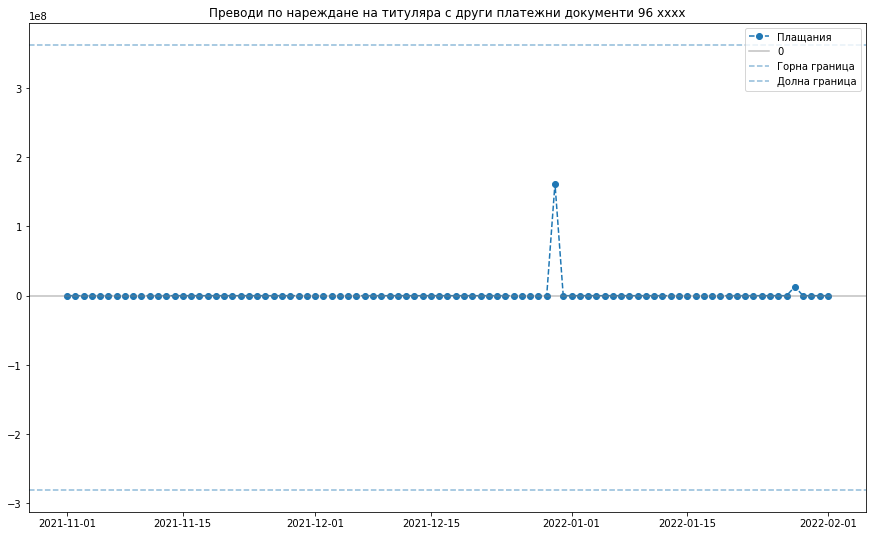

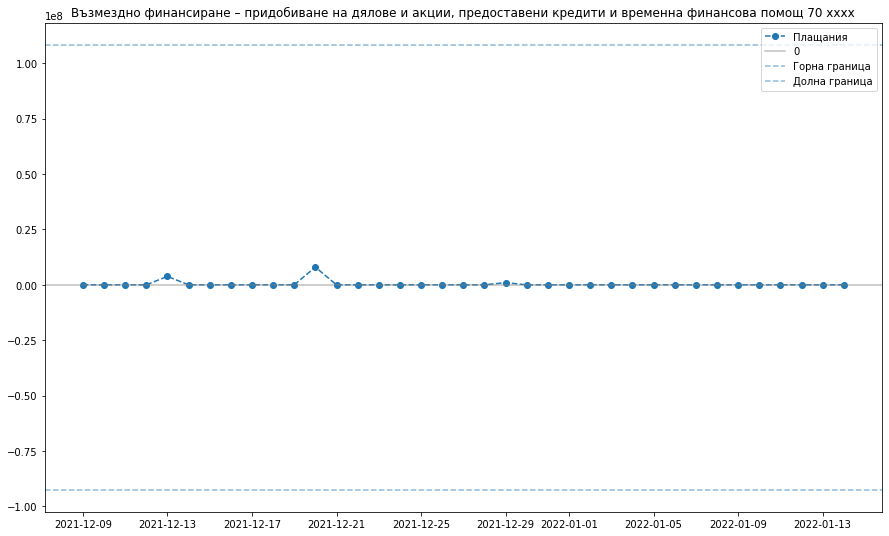

In [25]:
anomaly_choice_norm = 'anomaly_norm_nonzero'
# anomaly_choice_iqr = 'anomaly_iqr_nonzero' 

for code, op in code2operation.items():
    op_payments = df_grouped_by_op[
        (df_grouped_by_op['Operations Code']==code) &
        (df_grouped_by_op['Start Date'] >= pd.Timestamp('2021-11-01')) &
        (df_grouped_by_op['Start Date'] < pd.Timestamp('2023-01-01'))
    ].copy() 
    anomalies_norm = op_payments[op_payments[anomaly_choice_norm]>0].copy()
#     anomalies_iqr = op_payments[op_payments[anomaly_choice_iqr]>0].copy()
    
    if op_payments.shape[0] > 0:
        date_fill_df = pd.DataFrame({
            'Start Date': pd.date_range(op_payments['Start Date'].min(), op_payments['Start Date'].max())
        })
        op_payments = date_fill_df.merge(op_payments, on='Start Date', how='left')
        op_payments['Operations Amount (BGN)'].fillna(0, inplace=True)
        min_pay = op_payments['Operations Amount (BGN)'].min()
        max_pay = op_payments['Operations Amount (BGN)'].max()
        
        labels=["Плащания", 0,]
        plt.figure(figsize=(15, 9))
        plt.plot(op_payments['Start Date'], op_payments['Operations Amount (BGN)'], marker="o", linestyle="dashed")
        plt.vlines(anomalies_norm['Start Date'], min_pay, max_pay, colors='purple', alpha=0.5)
        plt.axhline(y=0, c='grey', alpha=0.5)
        
        if code2stats[code]!={}:
            plt.axhline(y=code2stats[code]['nonzero']['norm_high'], c='tab:blue', linestyle="--", alpha=0.5)
            plt.axhline(y=code2stats[code]['nonzero']['norm_low'], c='tab:blue', linestyle="--", alpha=0.5)
            labels.append('Горна граница')
            labels.append('Долна граница')
        
        if anomalies_norm.shape[0] > 0:
            labels.append('Аномалии')
            
        plt.legend(labels)
        plt.title(f"{op} {code}")
        plt.show()

# Investigate EoY big spendings

In [17]:
df_by_org = df_grouped_by_org.copy()
df_by_org['month'] = df_by_org['Start Date'].dt.month
df_by_org['year'] = df_by_org['Start Date'].dt.year
df_by_org['week'] = df_by_org['Start Date'].dt.week
df_by_org.head()

C:\Users\mariya.lazarova\AppData\Local\Temp\ipykernel_18996\3400399555.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_by_org['week'] = df_by_org['Start Date'].dt.week


Organization Name Organization ID  \
0  Kомисия за енергийно и водно регулиране ( 045*...      045*******   
1  Kомисия за енергийно и водно регулиране ( 045*...      045*******   
2  Kомисия за енергийно и водно регулиране ( 045*...      045*******   
3  Kомисия за енергийно и водно регулиране ( 045*...      045*******   
4  Kомисия за енергийно и водно регулиране ( 045*...      045*******   

                   Category Start Date  Operations Amount (BGN)  Latest Date  \
0  Министерства и ведомства 2019-01-08                 65103.05            0   
1  Министерства и ведомства 2019-01-09                  5000.00            0   
2  Министерства и ведомства 2019-01-11                  7061.23            0   
3  Министерства и ведомства 2019-01-18                  6338.53            0   
4  Министерства и ведомства 2019-01-21                   215.14            0   

   anomaly_norm_nonzero  anomaly_norm_zerofilled  anomaly_iqr_nonzero  \
0                   0.0                      0.0                  0.0   
1                   0.0                      0.0                  0.0   
2                   0.0                      0.0                  0.0   
3                   0.0                      0.0                  0.0   
4                   0.0                      0.0                  0.0   

   anomaly_iqr_zerofilled  month  year  week  
0                     1.0      1  2019     2  
1                     1.0      1  2019     2  
2                     1.0      1  2019     2  
3                     1.0      1  2019     3  
4                     0.0      1  2019     4

In [18]:
df_by_org_weekly = df_by_org.groupby(
    ['Organization Name', 'Organization ID', 'Category', 'year', 'week']
)['Operations Amount (BGN)'].sum().reset_index().rename(
    columns={'Operations Amount (BGN)': 'spending_BGN'}
)

df_by_org_monthly = df_by_org.groupby(
    ['Organization Name', 'Organization ID', 'Category', 'year', 'month']
)['Operations Amount (BGN)'].sum().reset_index().rename(
    columns={'Operations Amount (BGN)': 'spending_BGN'}
)
# df_by_org_monthly

In [19]:
# Weekly avgs
weekly_avg_yearly = df_by_org_weekly.groupby(
    ['Organization Name', 'Organization ID', 'Category', 'year']
)['spending_BGN'].mean().reset_index().rename(
    columns={'spending_BGN': 'weekly_avg_yearly'}
)

weekly_avg_overall = df_by_org_weekly.groupby(
    ['Organization Name', 'Organization ID', 'Category']
)['spending_BGN'].mean().reset_index().rename(
    columns={'Operations Amount (BGN)': 'weekly_avg_overall'}
)

weekly_avg_over_years = df_by_org_weekly.groupby(
    ['Organization Name', 'Organization ID', 'Category', 'week']
)['spending_BGN'].mean().reset_index().rename(
    columns={'spending_BGN': 'weekly_avg_over_years'}
)


# Monthly avgs
monthly_avg_yearly = df_by_org_monthly.groupby(
    ['Organization Name', 'Organization ID', 'Category', 'year']
)['spending_BGN'].mean().reset_index().rename(
    columns={'spending_BGN': 'monthly_avg_yearly'}
)

monthly_avg_overall = df_by_org_monthly.groupby(
    ['Organization Name', 'Organization ID', 'Category']
)['spending_BGN'].mean().reset_index().rename(
    columns={'spending_BGN': 'monthly_avg_overall'}
)

monthly_avg_over_years = df_by_org_monthly.groupby(
    ['Organization Name', 'Organization ID', 'Category', 'month']
)['spending_BGN'].sum().reset_index().rename(
    columns={'spending_BGN': 'monthly_avg_over_years'}
)


In [20]:
df_by_org_monthly = df_by_org_monthly.merge(
    monthly_avg_yearly, 
    on=['Organization Name', 'Organization ID', 'Category', 'year']
)
df_by_org_monthly['deviation_from_monthly_avg_yearly'] = np.around(
    df_by_org_monthly.spending_BGN - df_by_org_monthly.monthly_avg_yearly, 2
)


df_by_org_monthly = df_by_org_monthly.merge(
    monthly_avg_over_years, 
    on=['Organization Name', 'Organization ID', 'Category', 'month']
)
df_by_org_monthly['deviation_from_monthly_avg_over_years'] = np.around(
    df_by_org_monthly.spending_BGN - df_by_org_monthly.monthly_avg_over_years, 2
)


df_by_org_monthly = df_by_org_monthly.merge(
    monthly_avg_overall, 
    on=['Organization Name', 'Organization ID', 'Category']
)
df_by_org_monthly['deviation_from_monthly_avg_overall'] = np.around(
    df_by_org_monthly.spending_BGN - df_by_org_monthly.monthly_avg_overall, 2
)



In [21]:
# df_by_org_monthly[
#     (df_by_org_monthly.year==2021) & (df_by_org_monthly.month==12)
# ].sort_values(
#     'deviation_from_monthly_avg_yearly',
#     ascending=False
# ).reset_index(drop=True)

In [22]:
# df_by_org_monthly[
#     (df_by_org_monthly.year==2021) & (df_by_org_monthly.month==12)
# ].sort_values(
#     'deviation_from_monthly_avg_yearly',
#     ascending=False
# ).reset_index(drop=True).to_csv("monthly_deviations_from_mean_by_organization.csv", index=False)